<img src="lab_logo.png">

# iPython script for the Multi-Chromatic Stimulator Project
by MJY Zimmermann & P Bartel

Baden Lab, CRPC, School of Life Sciences, University of Sussex, United Kingdom

***

##### Source : https://github.com/BadenLab/Tetra-Chromatic-Stimulator

##### This project is Open Source licensed, released under CERN OHL v1.2 

***

This script calculates opsin spectra as described in [Govardovskii et al.](https://www.cambridge.org/core/journals/visual-neuroscience/article/in-search-of-the-visual-pigment-template/A4738E821720092B7F5A233C4AB4962B) (In search of the visual pigment template, 2000).

It then allows the estimation of photoceptor excitation caused by LED light sources used in the stimulator. To this end, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable and an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany). 

*__Note:__ This script is used for the tetrachromatic (zebrafish) version of the visual stimulator; it can be easily adapted to other animals with more spectral sensitivites and light source/filter combinations.*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import scipy as scipy
from scipy.optimize import curve_fit
from scipy import stats, integrate
from scipy.optimize import minimize
from scipy.signal import savgol_filter as savgol
from IPython.display import Image,HTML,display

***

# Setting global parameters
Here we defined the max absorbance for each cone opsin present in the Zebrafish. The following values are taken from 
[Allison et al](https://www.cambridge.org/core/journals/visual-neuroscience/article/visual-pigment-composition-in-zebrafish-evidence-for-a-rhodopsinporphyropsin-interchange-system/D7824490079257A101123EBD593C153C) (Visual pigment composition in zebrafish: Evidence for a rhodopsin–porphyropsin interchange system, 2004)

In [2]:
PeakWavelength = [565, 482, 411, 361]                   # Peak opsin absorbance wavelengths in nm (R,G,B,UV)
nCone = len(PeakWavelength)                             # Number of LED (4 in our tested stimulator)
nLED = 4                                                # Number of cones in the considered animal model

spectrumPath = ".//Spectrometer_Recording//Spectrum//"  # Set path to Spectrometer recording folder
powerPath = ".//Powermeter_Recording//"                 # Set path to Powermeter recording folder  
filterpath = ".//Filters//"                             # Set path to optical filters spectra


#### Figure Parameters

In [3]:
SpectraRange = (300,700)                   # Spectrum Range in nm displayed on the various graph 
FigureSize = (15,10)                       # Set the size of all spectra figures
FigureFontSize = 20                        # Set the font size for spectra figure labels
FigureTitleSize = 25                       # Set the font size for spectra figure titles

colour = ['r','g','b','m']                 # Set colour array for traces
colors = ["#ff471a",'#39e600','#3399ff','#ff80ff'] # Set colour array for traces
Colour = ['r--','g--','b--','m--']         # Set colour array for traces
colourmap = 'gnuplot'#'seismic'
Colourmap = 'gnuplot'
RGBA = [(0.8,0,0,0.2),(0,0.8,0,0.2),(0,0,0.8,0.2),(0.4,0,0.4,0.2)] # Set colour array for trace infils

#plt.style.use('dark_background')           # Set ploting style

#### Define a normalisation function

In [4]:
def normalise (myarray):
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray

#### Set a "rainbow" gradient that attributes a given wavelentgh (in nm) to its approximate RGB color value
This part of the code is taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python.

Based on Dan Bruton's code: http://www.physics.sfasu.edu/astro/color/spectra.html

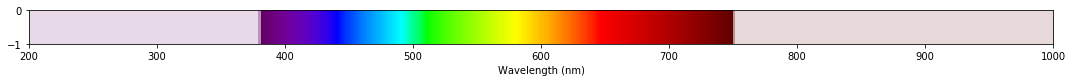

In [5]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.15
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(15,1.25), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)

y = np.linspace(0, -1, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylim(-1,0)
plt.fill_between(wavelengths, spectrum,  8, color='w');

#### Generate heatmap template for display purposes

In [6]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,fontsize=FigureFontSize)
    ax.set_yticklabels(row_labels,fontsize=FigureFontSize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, left = True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",textcolors=["white", "black"],threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

***

***

## Extract Spectrometer Recording to obtain LED spectra profile 
To determine the LEDs spectra, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable.

The following script is configured by default for ThorLab Spectrometer recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified.

Here the [calibration sequence](https://github.com/BadenLab/Tetra-Chromatic-Stimulator/tree/master/Spectrum%20Calibration/Arduino%20Code%20for%20Calibration%20Sequence) was used. LEDs are successively played from 0 to 100

In [7]:
nLoops = 5                           # Number of recording loop (5 in the submitted example)
nPoints = 100                        # Number of recording point per LED (100 in the current example (from 1 to 100% light intensity with an increment of 1))
SpectraNumber = nLoops*nLED*nPoints  # Total recording point number
ExcludePoints = 7                    # Number of point to discard at the end of recording
FirstPoint = 33                      # Start of the recording point in the csv file (33 in the submitted example)
SpectraStart = 19                    # First recording point (in our example: Spectrum000000019)
lenSpectra = 9                       # Length of the file string number (9 for ThorLab Spectrometer)

Spectra = []
for j in range(0,SpectraNumber):
    FileNumber = str(SpectraStart+j)
    FileNumber = FileNumber.rjust(lenSpectra,'0')
    FileName = spectrumPath + 'Spectrum' + FileNumber + '.csv'
    a = np.asarray(pd.read_csv(FileName))[FirstPoint:-1,:].reshape(-1)
    a2 = np.asarray([a[i][17:] for i in range(a.shape[0])]).astype(float)
    Spectra.append(a2)
    
Spectra = np.asarray(Spectra)
WvsX = np.asarray([a[i][:16] for i in range(a.shape[0])]).astype(float)
Spectra=Spectra.reshape(nLoops,nLED*nPoints,-1)
Spectra = np.mean(Spectra,axis = 0)


# Generate Opsin Template
This code fits Govardovskii (A1) templates to desired peak wavelengths: lambdamax - [Govardovskii et al.](https://www.cambridge.org/core/journals/visual-neuroscience/article/in-search-of-the-visual-pigment-template/A4738E821720092B7F5A233C4AB4962B) (In search of the visual pigment template, 2000). Itself adapted from the template described by [Lamb et al](https://www.sciencedirect.com/science/article/pii/004269899500114F?via%3Dihub) (Photoreceptor Spectral Sensitivities:Common Shape in the Long-wavelength Region)

***

#### AlphaBand     $$S\alpha(x) = \frac{1}{exp[A(a-x)] + exp[B(b-x)] + exp[C(c-x)] + D}$$

Where $x$ = $\frac{\lambda max}{\lambda}$

With $a$ the only variable parameter such as $a$ = $0.8795 + 0.0459 * exp^{\frac{(\lambda max -300)^{2}}{11940}}$, and constant parameters (A, B, b, C, c, D) as defined below.

***

#### BetaBand      $$S\beta(\lambda) = A\beta * exp^{-(\frac{\lambda - \lambda m\beta}{b})^{2}}$$

With $A\beta$  the amplitude of the $\beta band$ relative to the $\alpha band$, $\lambda m\beta$ the position of the $\beta peak$ and $b$ a bandwidth parameter


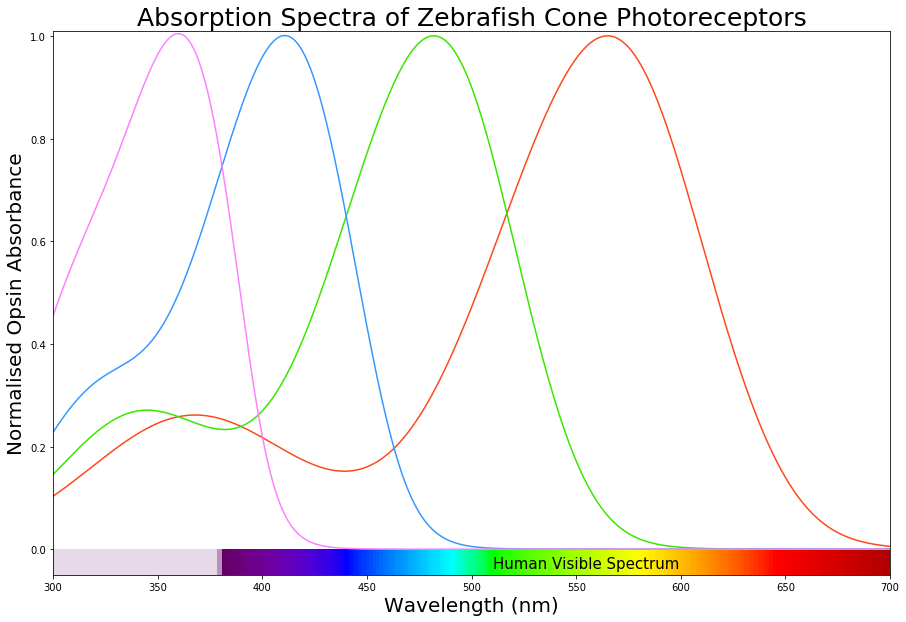

In [8]:
def Govardovskii (wvsloc, lambdamax):
   '''This function returns one sensitivity spectrum point y at wavelength = wvs of an opsin  with a peak at lambdamax, wvs - such wavelengths at which the template will be evaluated: 1d-array lambdamax - peak of the sensitivity spectrum'''
   wvs = np.asarray(wvsloc)

   ##### AlphaBand ######
   A = 69.7
   a = 0.8795+0.0459*np.exp(-np.square(lambdamax-300)/11940)
   B = 28
   b = 0.922
   C = -14.9
   c = 1.104
   D = 0.674
   x = lambdamax/wvs
   alphaband = 1/ (np.exp(A*(a-x))+np.exp(B*(b-x))+np.exp(C*(c-x))+D)
   
   ##### BetaBand ######
   Ab = 0.26 #Beta value at peak
   b = -40.5+0.195*lambdamax #Beta bandwidth
   Lamb = 189+0.315*lambdamax #Beta peak
   betaband = Ab * np.exp(-1*((wvs-Lamb)/b)**2)
   return alphaband+betaband


fig,ax = plt.subplots(1,1,figsize = FigureSize)

Opsin =[]

for i in range (nCone):
    opsin = Govardovskii(WvsX,PeakWavelength[i])
    Opsin.append(opsin)
    
    ax.plot(WvsX,Opsin[i],c=colors[i])
    

ax.set_title('Absorption Spectra of Zebrafish Cone Photoreceptors', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Opsin Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color="black", fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);

fig.savefig('Calibration_Figures//Cone Absoprtion Spectra.png')

# Generate LED spectral profiles 

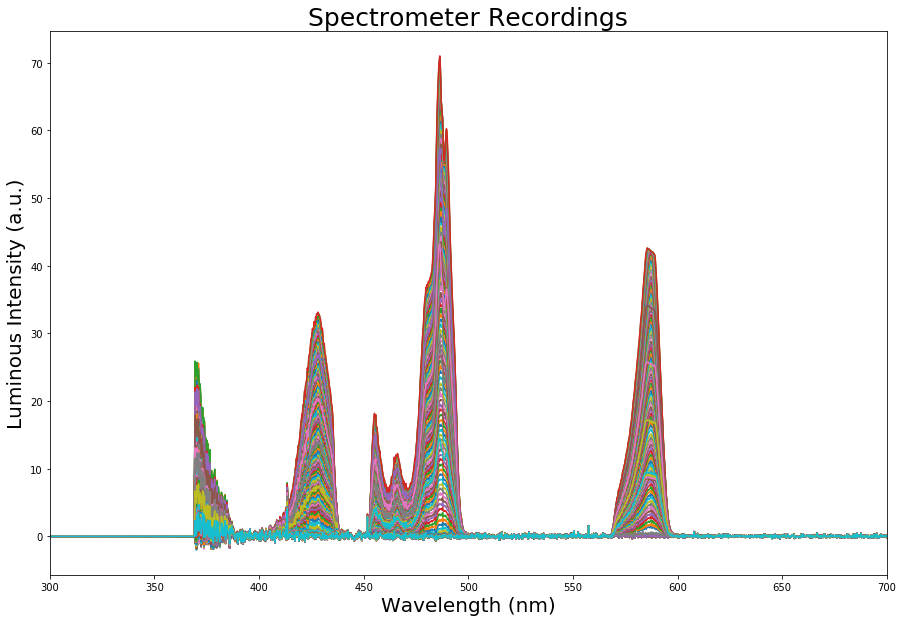

In [9]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Spectra[i,:]) for i in range(nLED*nPoints)]

ax.set_title('Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange));
fig.savefig('Calibration_Figures//Spectrometer Recordings.png')

#### Use a Savitzky–Golay filter to smooth the recorded "Spectra" traces

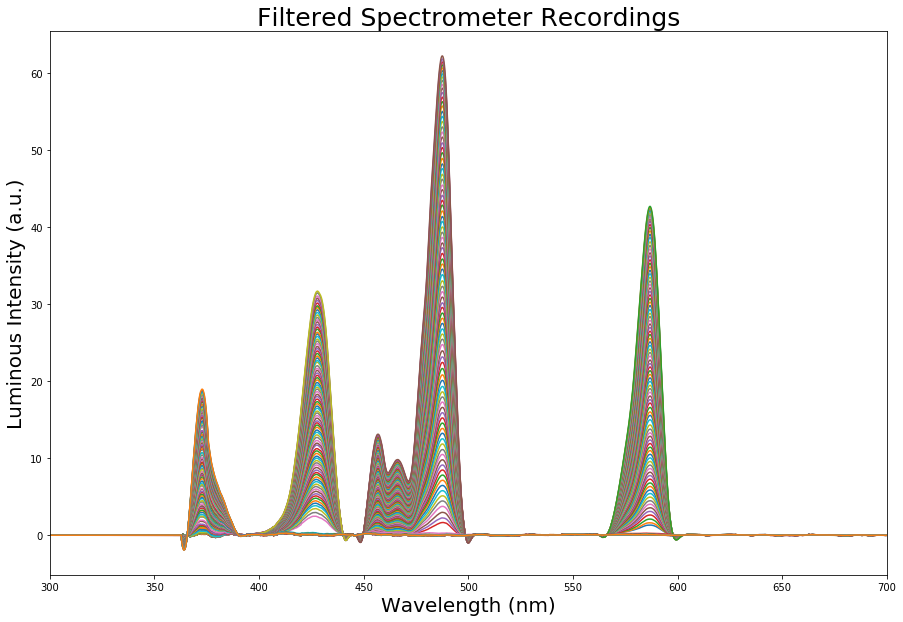

In [10]:
savgolWindow = 61   # The length of the filter window
savgolOrder = 2     # The order of the polynomial used to fit the samples.
savgolDelta = 1     # The spacing of the samples to which the filter will be applied.

Smoothed = savgol(Spectra, savgolWindow, savgolOrder, delta = savgolDelta, axis = -1)
Smoothed = Smoothed.reshape(nLED,nPoints,-1)
Smoothed = Smoothed[:,:-ExcludePoints,:]

fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])]

ax.set_title('Filtered Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange));
fig.savefig('Calibration_Figures//Filtered Spectrometer Recordings.png')

#### Plot all normalised LED intensity value individually

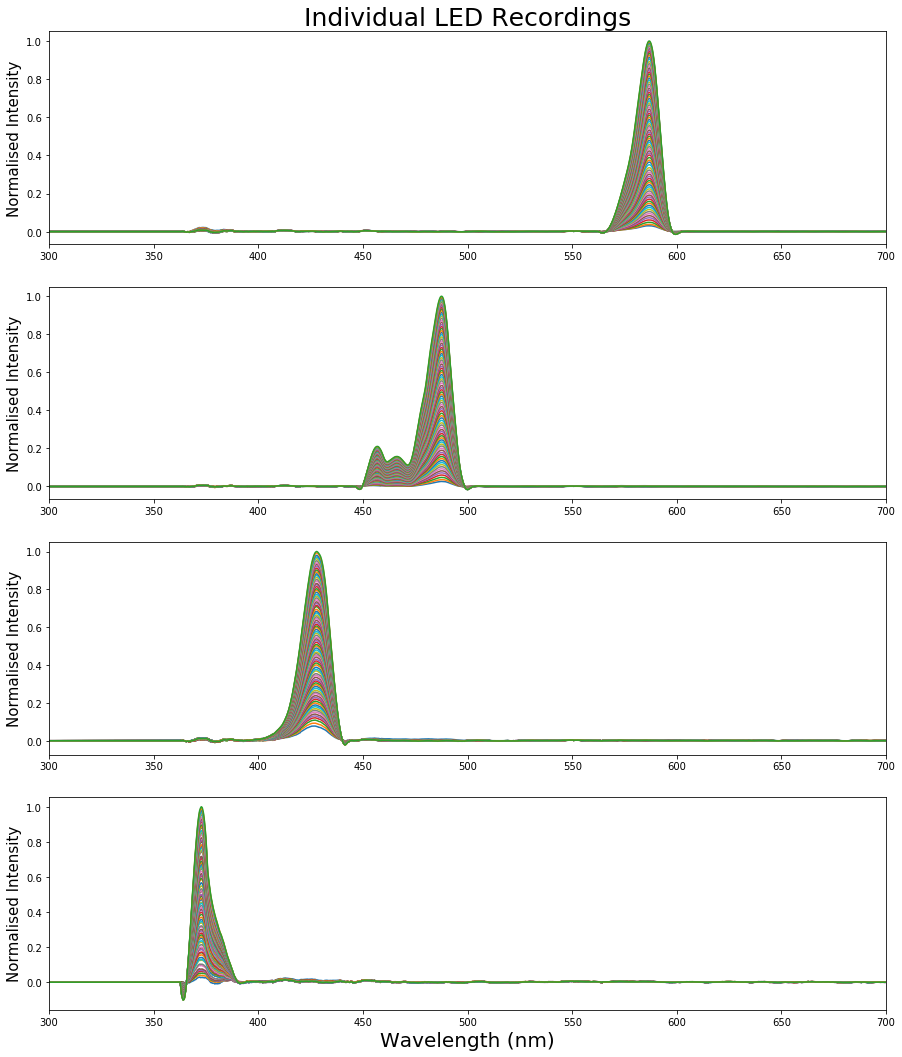

In [11]:
fig,ax = plt.subplots(4,1,figsize = (15,18))

Smoothed_norm = np.stack([Smoothed[i,:,:]/np.amax(Smoothed[i,:,:]) for i in range(nLED)])

[ax[0].plot(WvsX,Smoothed_norm[0,i,:]) for i in range(Smoothed.shape[1])];
[ax[1].plot(WvsX,Smoothed_norm[1,i,:]) for i in range(Smoothed.shape[1])];
[ax[2].plot(WvsX,Smoothed_norm[2,i,:]) for i in range(Smoothed.shape[1])];
[ax[3].plot(WvsX,Smoothed_norm[3,i,:]) for i in range(Smoothed.shape[1])];


[ax[0].set_title('Individual LED Recordings', fontsize = FigureTitleSize)]
[ax[i].set_xlabel('Wavelength (nm)', fontsize = FigureFontSize) for i in [3]]
[ax[i].set_ylabel('Normalised Intensity', fontsize = 15) for i in [0,1,2,3]]

[ax[i].set_xlim(SpectraRange) for i in [0,1,2,3]];

### Determine peak wavelength for each LED in nm

In [12]:
MaxesIndices = np.argmax(Smoothed[:,-1,:],axis = -1)

Peaks = WvsX[MaxesIndices]
Peaks = np.around(Peaks,decimals=1)

LEDS = ['Red','Green','Blue','UV'] 
[print (LEDS[i] + ' LED Peak Wavelength = ' + '\033[1m''\033[4m'  "%.4g"  % Peaks[i] + 'nm' '\033[0m') for i in range (nLED)];

Red LED Peak Wavelength = 586.9nm
Green LED Peak Wavelength = 487.5nm
Blue LED Peak Wavelength = 427.9nm
UV LED Peak Wavelength = 372.8nm


***

### Setting functions and parameters to establish LED performances

In [13]:
def linfunc(x,param):
    a,b = param
    return a+b*x

def linfunc_error(param,x,y):
    """x is current, param is a vector of length 2, y is all luminescence values"""
    y_pred = linfunc(x,param)
    return np.sum((y-y_pred)**2)/y.shape[0]


x0 = [1,1] # initial guess for a,b
Args = []
Solution = []
SSE = []

for i in range (nLED):
    args = (np.arange(1,nPoints-ExcludePoints+1),np.sum(Smoothed[i,:,:],axis=-1))
    Args.append(args)
    
    solution = minimize(linfunc_error, x0 = x0, args = Args[i]).x
    Solution.append(solution)
    
    sse = np.sqrt(linfunc_error(Solution[i], Args[i][0], Args[i][1]))
    sse = np.around(sse,decimals=2)
    SSE.append(sse)

#### Plot LEDs intensities (relative output power) against their forward current

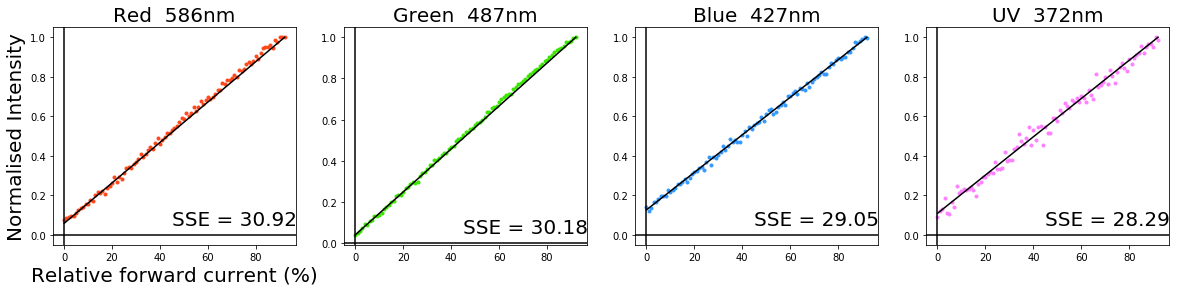

In [14]:
fig,ax = plt.subplots(1,nLED,figsize = (20,4))
titles = ['Red  '+str(int(Peaks[0]))+'nm','Green  '+str(int(Peaks[1]))+'nm','Blue  '+str(int(Peaks[2]))+'nm','UV  '+str(int(Peaks[3]))+'nm']

SSE_Font = 20
SSE_x = 45
SSE_y = 0.05

for i in range (nLED):
    ax[i].plot(normalise(np.sum(Smoothed[i,:,:],axis=-1)),'.',color = colors[i])
    
    ax[i].plot(normalise(linfunc(Args[i][0],Solution[i])),"k", color = 'black')
    ax[i].text(SSE_x,SSE_y,'SSE = '+str(SSE[i]),fontsize=SSE_Font)
    
    ax[i].axhline(color = 'black')
    ax[i].axvline(color = 'black')
    
    ax[i].set_title(titles[i], fontsize = FigureFontSize)
    
    ax[0].set_xlabel('Relative forward current (%)', fontsize = FigureFontSize)
    ax[0].set_ylabel('Normalised Intensity', fontsize = FigureFontSize)


fig.savefig('Calibration_Figures//Normalised Intensity VS Forward Current.png')

### Plot LED spectra

In [15]:
Red_Filter = np.loadtxt(filterpath + "Red_Filter.txt")
Green_Filter = np.loadtxt(filterpath + "Green_Filter.txt")
Blue_Filter = np.loadtxt(filterpath + "Blue_Filter.txt")
UV_Filter = np.loadtxt(filterpath + "UV_Filter.txt")

UV_RGB_Dichroic = np.loadtxt(filterpath + "UV-RGB_Dichroic.txt")
B_RG_Dichroic = np.loadtxt(filterpath + "B-RG_Dichroic.txt")
G_R_Dichroic = np.loadtxt(filterpath + "G-R_Dichroic.txt")

PMT1 = np.loadtxt(filterpath + "PMT_1.txt")
PMT2 = np.loadtxt(filterpath + "PMT_2.txt")

Laser_Dichroic = np.loadtxt(filterpath + "Laser_Dichroic.txt")
Objective_Dichroic = np.loadtxt(filterpath + "Objective_Dichroic.txt")

# Plot LED spectra against the zebrafish cone absorbance spectra. 


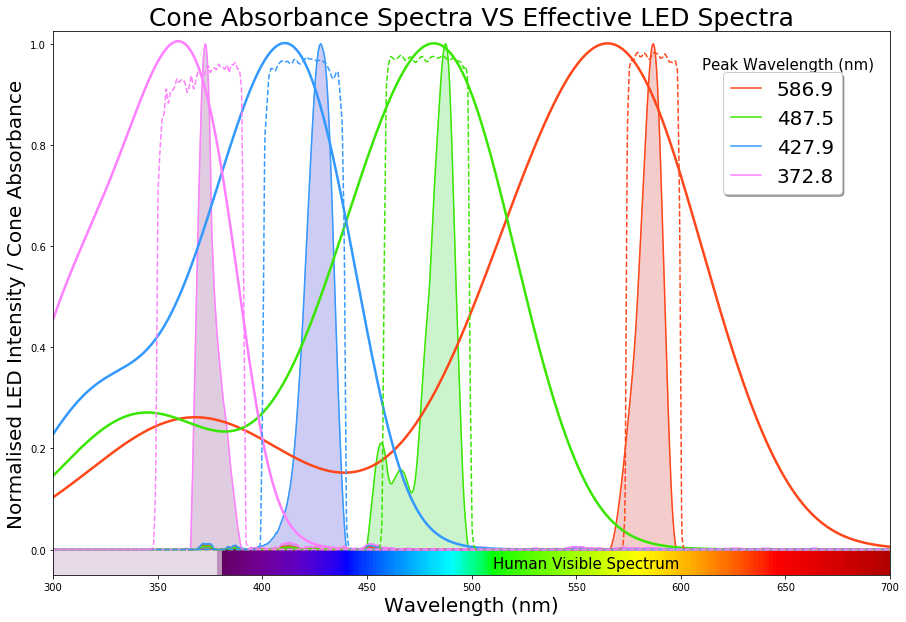

In [16]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

LEDNormalised = []
LEDnormalised = []

for i in range (nLED):

    LEDNorm = np.divide(Smoothed[i,nPoints-ExcludePoints-1,:],np.amax(Smoothed[i,nPoints-ExcludePoints-1,:]))
    LEDNormalised.append(LEDNorm)

    LEDnorm = np.copy(LEDNormalised[i])
    LEDnorm[LEDnorm<0] = 0
    LEDnormalised.append(LEDnorm)
    
    ax.plot(WvsX,LEDnormalised[i],colors[i])
    ax.fill(WvsX,LEDnormalised[i], c=RGBA[i])
    
for i in range (nCone):
    ax.plot(WvsX, Opsin[i], colors[i],linewidth=2.5)


ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.025)

plt.plot(WvsX,Red_Filter,'--',color=colors[0],linewidth=1.5)
plt.plot(WvsX,Green_Filter,'--',color=colors[1],linewidth=1.5)
plt.plot(WvsX,Blue_Filter,'--',color=colors[2],linewidth=1.5)
plt.plot(WvsX,UV_Filter,'--',color=colors[3],linewidth=1.5)

ax.set_title('Cone Absorbance Spectra VS Effective LED Spectra', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = FigureFontSize)

plt.legend((Peaks[0], Peaks[1], Peaks[2], Peaks[3]), shadow=True, loc=(0.8, 0.7), handlelength=1.5, fontsize=20)
plt.text(610,0.95, 'Peak Wavelength (nm)', fontsize=15);

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)

plt.savefig("Calibration_Figures//Opsin-LED Spectra.png")

# Plot LEDs / Filters / Dichroic Mirrors used in the stimulators

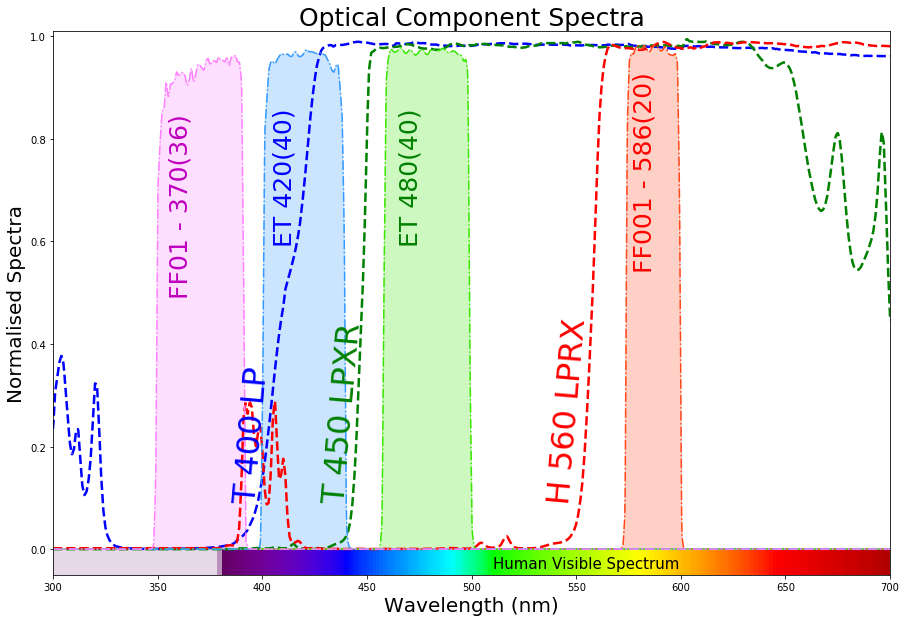

In [17]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

ax.set_title('Optical Component Spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Spectra', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color='black', fontsize=15)

plt.plot(WvsX,UV_RGB_Dichroic,'--',color='b',linewidth=2.5)
plt.plot(WvsX,B_RG_Dichroic,'--',color='g',linewidth=2.5)
plt.plot(WvsX,G_R_Dichroic,'--',color='r',linewidth=2.5)

plt.plot(WvsX,Red_Filter,'-.',color=colors[0],linewidth=1.5)
plt.plot(WvsX,Green_Filter,'-.',color=colors[1],linewidth=1.5)
plt.plot(WvsX,Blue_Filter,'-.',color=colors[2],linewidth=1.5)
plt.plot(WvsX,UV_Filter,'-.',color=colors[3],linewidth=1.5)
plt.fill(WvsX,Red_Filter,'-.',color=colors[0],alpha=0.25)
plt.fill(WvsX,Green_Filter,'-.',color=colors[1],alpha=0.25)
plt.fill(WvsX,Blue_Filter,'-.',color=colors[2],alpha=0.25)
plt.fill(WvsX,UV_Filter,'-.',color=colors[3],alpha=0.25)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);
   
plt.text(535, 0.1, 'H 560 LPRX', color='r', fontsize=32, rotation=85)
plt.text(427.5, 0.1, 'T 450 LPXR', color='g', fontsize=32, rotation=85)
plt.text(385, 0.1, 'T 400 LP', color='b', fontsize=32, rotation=85)
plt.text(577, 0.55, 'FF001 - 586(20)', color='r', fontsize=25, rotation=90)
plt.text(465, 0.6, 'ET 480(40)', color='g', fontsize=25, rotation=90)
plt.text(405, 0.6, 'ET 420(40)', color='b', fontsize=25, rotation=90)
plt.text(355, 0.5, 'FF01 - 370(36)', color='m', fontsize=25, rotation=90)

plt.savefig("Calibration_Figures//Optics_Spectra.png")

# Plot LEDs / Filters Spectra with PMT detection bands spectra

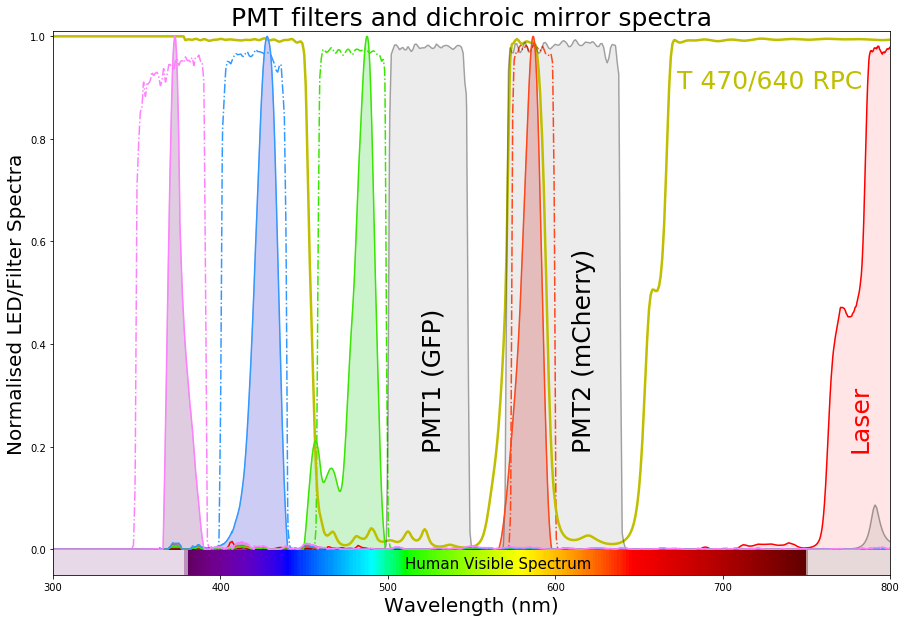

In [18]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

ax.set_title('PMT filters and dichroic mirror spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised LED/Filter Spectra', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color='black', fontsize=15)

plt.plot(WvsX,Red_Filter,'-.',color=colors[0],linewidth=1.5)
plt.plot(WvsX,Green_Filter,'-.',color=colors[1],linewidth=1.5)
plt.plot(WvsX,Blue_Filter,'-.',color=colors[2],linewidth=1.5)
plt.plot(WvsX,UV_Filter,'-.',color=colors[3],linewidth=1.5)

plt.plot(WvsX,Laser_Dichroic,'-',color='r',linewidth=1.5)
plt.fill(WvsX,Laser_Dichroic,c = (1,0,0,0.1))

plt.plot(WvsX,Objective_Dichroic,'y',linewidth=2.5)

ax.set_xlim((300,800))
ax.set_ylim(-0.05,1.01);

plt.plot(WvsX,PMT1,c = (0,0,0,0.3))
plt.plot(WvsX,PMT2,c = (0,0,0,0.3))
plt.fill(WvsX,PMT1,c = (0.3,0.3,0.3,0.1))
plt.fill(WvsX,PMT2,c = (0.3,0.3,0.3,0.1))


LEDNormalised = []
LEDnormalised = []

for i in range (nLED):

    LEDNorm = np.divide(Smoothed[i,nPoints-ExcludePoints-1,:],np.amax(Smoothed[i,nPoints-ExcludePoints-1,:]))
    LEDNormalised.append(LEDNorm)

    LEDnorm = np.copy(LEDNormalised[i])
    LEDnorm[LEDnorm<0] = 0
    LEDnormalised.append(LEDnorm)
    
    ax.plot(WvsX,LEDnormalised[i],colors[i])
    ax.fill(WvsX,LEDnormalised[i], c=RGBA[i])
   
plt.text(520, 0.2, 'PMT1 (GFP)', color='k', fontsize=25, rotation=90)
plt.text(610, 0.2, 'PMT2 (mCherry)', color='k', fontsize=25, rotation=90)
plt.text(672.5, 0.9, 'T 470/640 RPC', color='y', fontsize=25, rotation=0)
plt.text(775, 0.2, 'Laser',color='r', fontsize=25, rotation=90)

plt.savefig("Calibration_Figures//LED-PMT_Spectra.png")

# Estimate relative co-excitation of photoreceptors by the LEDs


C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


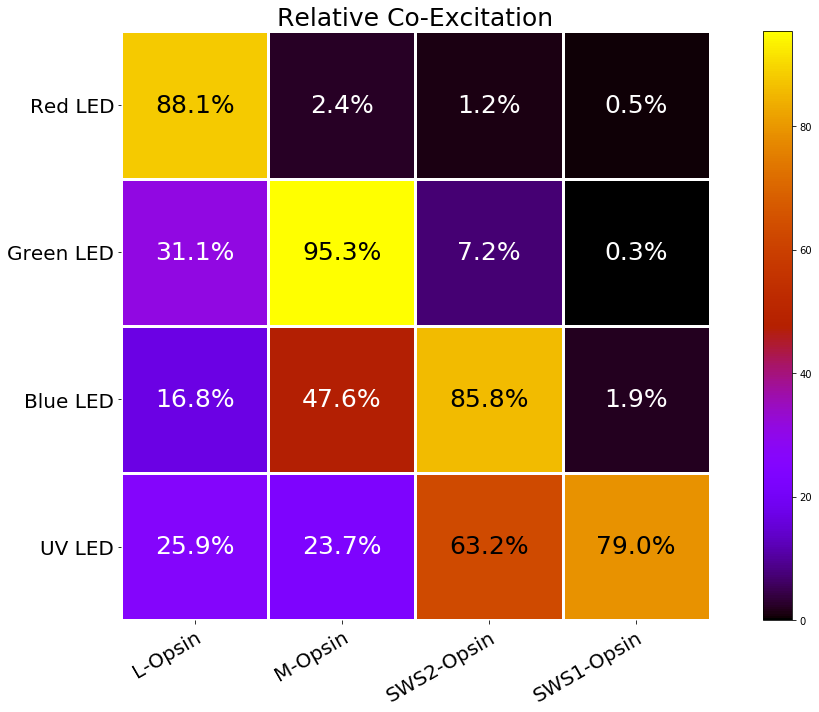

In [19]:
Ops = np.asarray(Opsin)
Ops = Ops.swapaxes(1,0)

led = np.asarray(LEDnormalised)
led = led.swapaxes(1,0)


M0 = np.zeros((nCone,nLED, len(led[:,0])))        # M0 is needed to take integrals over LED*OPS
M = np.zeros((nCone,nLED))                        # M1 is the M matrix of Estevez, gives vector of response changes (r) from vector of stimulus changes (s): r = M1*s
M1 = np.zeros((nCone,nLED))


for iCone in range(0,(nCone)):                    # For each cone...
    for iLED in range(0,(nLED)):                     # For each LED...
        M0[iCone,iLED,:] = Ops[:,iCone]*led[:,iLED]            # Multiply Ops and Led elements 
        M[iCone,iLED] = np.sum(M0[iCone,iLED,:])               # Generate a cross activation integral M = (Ops*Led)
        M1[iCone,iLED] = M[iCone,iLED]/np.sum(led[:,iLED])     # Divide the cross activation integral by the LED integral M1 = M/Led
        
# Display M matrix
M1_Matrix = M1*100
M1_Matrix = M1_Matrix.swapaxes(1,0)
vmx = np.amax(np.abs(M1_Matrix.reshape(-1)))
vmn = 0

Cones = ["L-Opsin", "M-Opsin", "SWS2-Opsin", "SWS1-Opsin"]
LEDs = ["Red LED", "Green LED", "Blue LED","UV LED"]

ax.set_xticks(np.arange(len(LEDs)))
ax.set_yticks(np.arange(len(Cones)))
ax.set_xticklabels(LEDs)
ax.set_yticklabels(Cones)

plt.setp(ax.get_xticklabels(), rotation=45, ha="left",rotation_mode="anchor")

fig, (ax1) = plt.subplots(1, 1, figsize=FigureSize)

im, _ = heatmap(M1_Matrix, LEDs, Cones, ax=ax1, cmap=colourmap, vmax = vmx, vmin = vmn)
annotate_heatmap(im, valfmt="{x:.1f}%", size=FigureFontSize+5)

ax1.set_title('Relative Co-Excitation', fontsize = FigureTitleSize)

fig.tight_layout();

fig.savefig('Calibration_Figures//Relative Co-Excitation Matrix.png')

## Plot the Relative Coexcitation (M) Matrix for each cone over its spectra spectra 

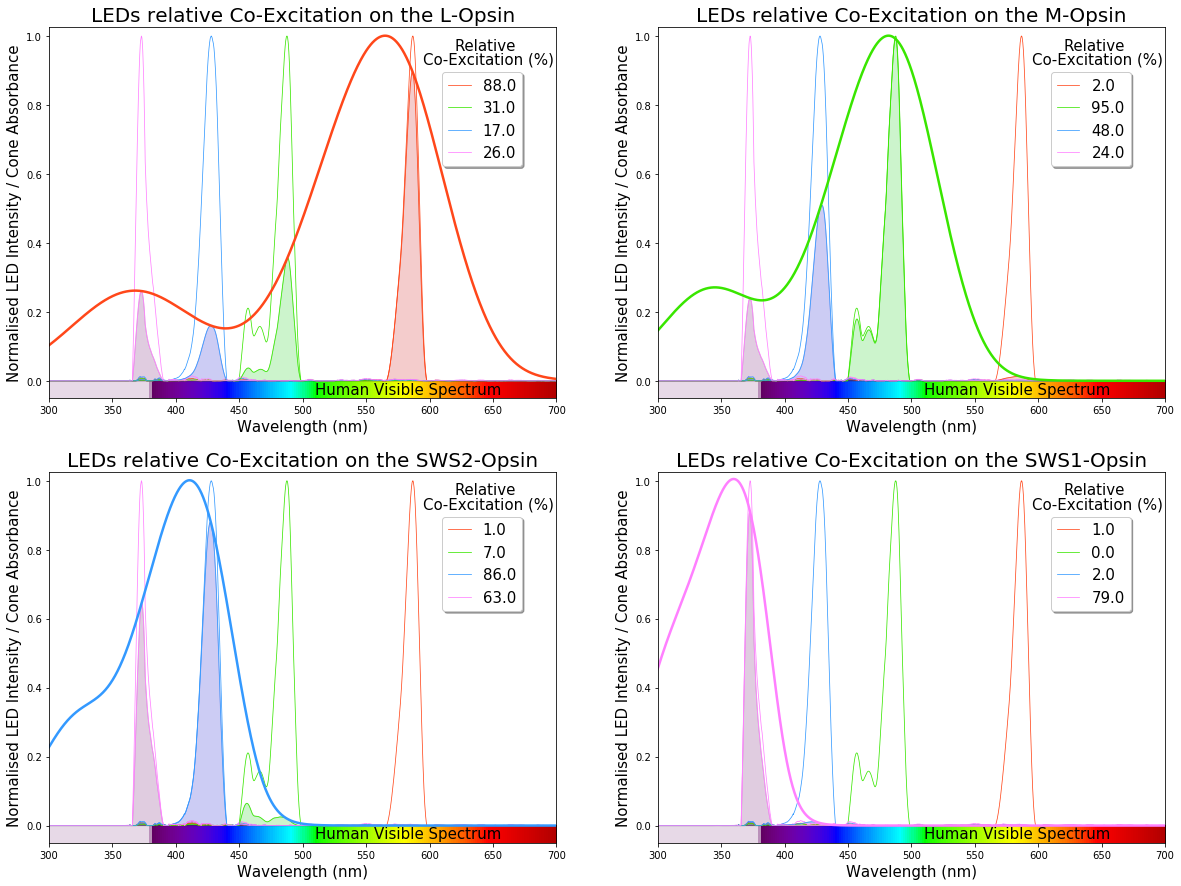

In [20]:
fig,ax = plt.subplots(2,2,figsize = (20,15))


for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[i], colors[i],linewidth=0.75)
ax[0,0].legend((np.around(M1_Matrix[0][0]), np.around(M1_Matrix[1][0]), np.around(M1_Matrix[2][0]), np.around(M1_Matrix[3][0])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,0].text(620,0.96, 'Relative', fontsize=15);
ax[0,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[i]*Opsin[0], colors[i],linewidth=0.75)
    ax[0,0].fill(WvsX, LEDnormalised[i]*Opsin[0], c=RGBA[i])
ax[0,0].plot(WvsX, Opsin[0], colors[0],linewidth=2.5)
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('LEDs relative Co-Excitation on the L-Opsin', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[i], colors[i],linewidth=0.75)
ax[0,1].legend((np.around(M1_Matrix[0][1]), np.around(M1_Matrix[1][1]), np.around(M1_Matrix[2][1]), np.around(M1_Matrix[3][1])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,1].text(620,0.96, 'Relative', fontsize=15);
ax[0,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[i]*Opsin[1], colors[i],linewidth=0.75)
    ax[0,1].fill(WvsX, LEDnormalised[i]*Opsin[1], c=RGBA[i])
ax[0,1].plot(WvsX, Opsin[1], colors[1],linewidth=2.5)
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('LEDs relative Co-Excitation on the M-Opsin', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[i], colors[i],linewidth=0.75)
ax[1,0].legend((np.around(M1_Matrix[0][2]), np.around(M1_Matrix[1][2]), np.around(M1_Matrix[2][2]), np.around(M1_Matrix[3][2])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,0].text(620,0.96, 'Relative', fontsize=15);
ax[1,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[i]*Opsin[2], colors[i],linewidth=0.75)
    ax[1,0].fill(WvsX, LEDnormalised[i]*Opsin[2], c=RGBA[i])
ax[1,0].plot(WvsX, Opsin[2], colors[2],linewidth=2.5)
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('LEDs relative Co-Excitation on the SWS2-Opsin', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[i], colors[i],linewidth=0.75)
ax[1,1].legend((np.around(M1_Matrix[0][3]), np.around(M1_Matrix[1][3]), np.around(M1_Matrix[2][3]), np.around(M1_Matrix[3][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,1].text(620,0.96, 'Relative', fontsize=15);
ax[1,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[i]*Opsin[3], colors[i],linewidth=0.75)
    ax[1,1].fill(WvsX, LEDnormalised[i]*Opsin[3], c=RGBA[i])
ax[1,1].plot(WvsX, Opsin[3], colors[3],linewidth=2.5)
ax[1,1].set_xlim(SpectraRange);
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)  
ax[1,1].set_title('LEDs relative Co-Excitation on the SWS1-Opsin', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);

fig.savefig('Calibration_Figures//LED-Opsin Co-Excitation.png')

## Plot the Relative Coexcitation (M) Matrix for each LED over its spectra spectra 

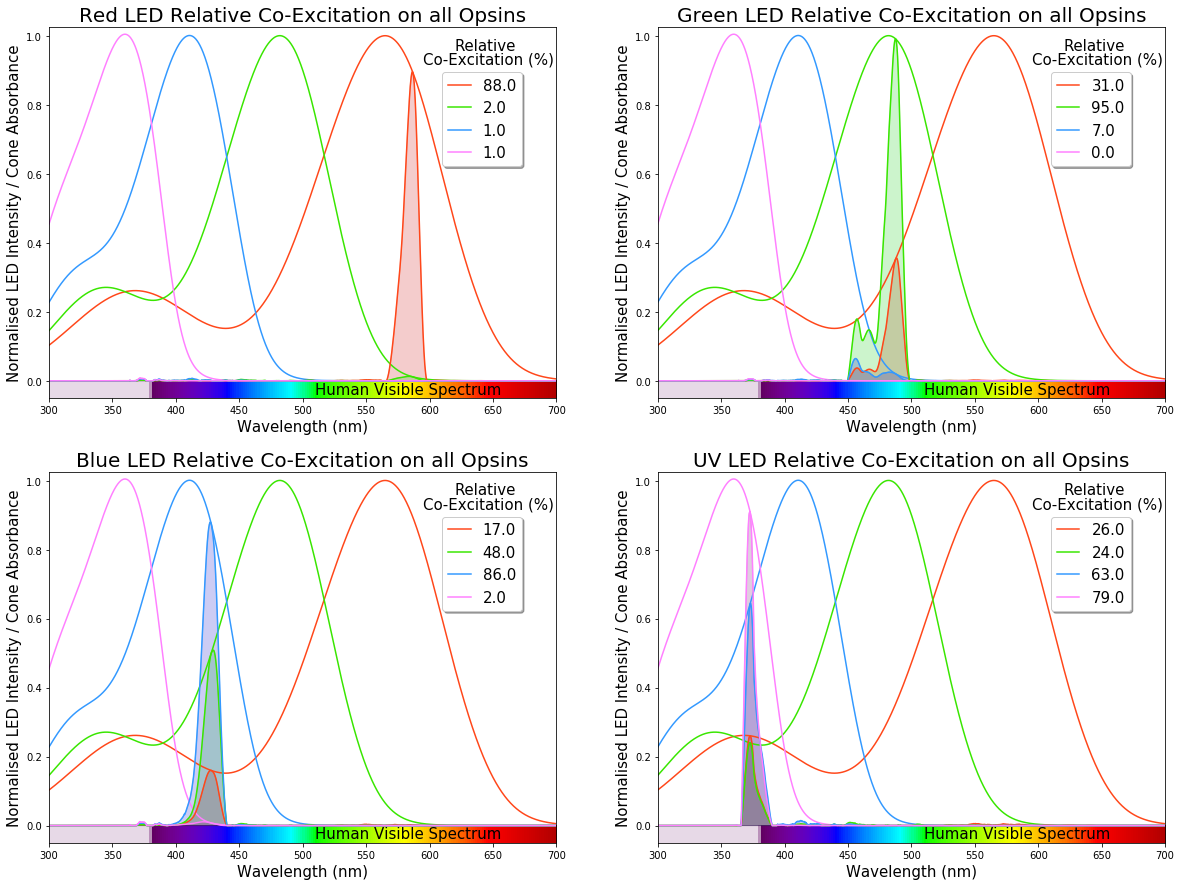

In [21]:
fig,ax = plt.subplots(2,2,figsize = (20,15))

for i in range (nCone):
    ax[0,0].plot(WvsX, Opsin[i], colors[i])
ax[0,0].legend((np.around(M1_Matrix[0][0]), np.around(M1_Matrix[0][1]), np.around(M1_Matrix[0][2]), np.around(M1_Matrix[0][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,0].text(620,0.96, 'Relative', fontsize=15);
ax[0,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[0]*Opsin[i], colors[i])
    ax[0,0].fill(WvsX, LEDnormalised[0]*Opsin[i], c=RGBA[i])
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('Red LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[0,1].plot(WvsX, Opsin[i], colors[i])
ax[0,1].legend((np.around(M1_Matrix[1][0]), np.around(M1_Matrix[1][1]), np.around(M1_Matrix[1][2]), np.around(M1_Matrix[1][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,1].text(620,0.96, 'Relative', fontsize=15);
ax[0,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[1]*Opsin[i], colors[i])
    ax[0,1].fill(WvsX, LEDnormalised[1]*Opsin[i], c=RGBA[i])
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('Green LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,0].plot(WvsX, Opsin[i], colors[i])
ax[1,0].legend((np.around(M1_Matrix[2][0]), np.around(M1_Matrix[2][1]), np.around(M1_Matrix[2][2]), np.around(M1_Matrix[2][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,0].text(620,0.96, 'Relative', fontsize=15);
ax[1,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[2]*Opsin[i], colors[i])
    ax[1,0].fill(WvsX, LEDnormalised[2]*Opsin[i], c=RGBA[i])  
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('Blue LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,1].plot(WvsX, Opsin[i], colors[i])
ax[1,1].legend((np.around(M1_Matrix[3][0]), np.around(M1_Matrix[3][1]), np.around(M1_Matrix[3][2]), np.around(M1_Matrix[3][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,1].text(620,0.96, 'Relative', fontsize=15);
ax[1,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[3]*Opsin[i], colors[i])
    ax[1,1].fill(WvsX, LEDnormalised[3]*Opsin[i], c=RGBA[i])  
ax[1,1].set_xlim(SpectraRange)
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,1].set_title('UV LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);


fig.savefig('Calibration_Figures//Opsin-LED Co-Excitation.png')

***

# Extract Powermeter Recording to determine the Electrical Power (in nW)
Here, we used an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany).

The following script is configured by default for ThorLab Powermeter recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified

In [22]:
r_sensor_um = (9.5/2)*1000                              # Set the sensor radius in micrometer 
SensorArea = np.pi*(r_sensor_um**2)                     # Calculate the sensor area

Steps = 101                                             # Set the number of recording points for each LED
Red_FirstRecording = 22                                 # Set for the Red recording the first recording point
Red_LastRecording = Red_FirstRecording + Steps
Green_FirstRecording = 22                               # Set for the Green recording the first recording point
Green_LastRecording = Green_FirstRecording + Steps
Blue_FirstRecording = 23                                # Set for the Blue recording the first recording point
Blue_LastRecording = Blue_FirstRecording + Steps
UV_FirstRecording = 24                                  # Set for the UV recording the first recording point
UV_LastRecording = UV_FirstRecording + Steps

Red_FileName = powerPath + 'Red.csv'                    # Import the Red recording (Red.csv has to be the name of the recording csv file)
Green_FileName = powerPath + 'Green.csv'                # Import the Green recording (Red.csv has to be the name of the recording csv file)
Blue_FileName = powerPath + 'Blue.csv'                  # Import the Blue recording (Red.csv has to be the name of the recording csv file)
UV_FileName = powerPath + 'UV.csv'                      # Import the UV recording (Red.csv has to be the name of the recording csv file)

## Plot power readings for each LED 

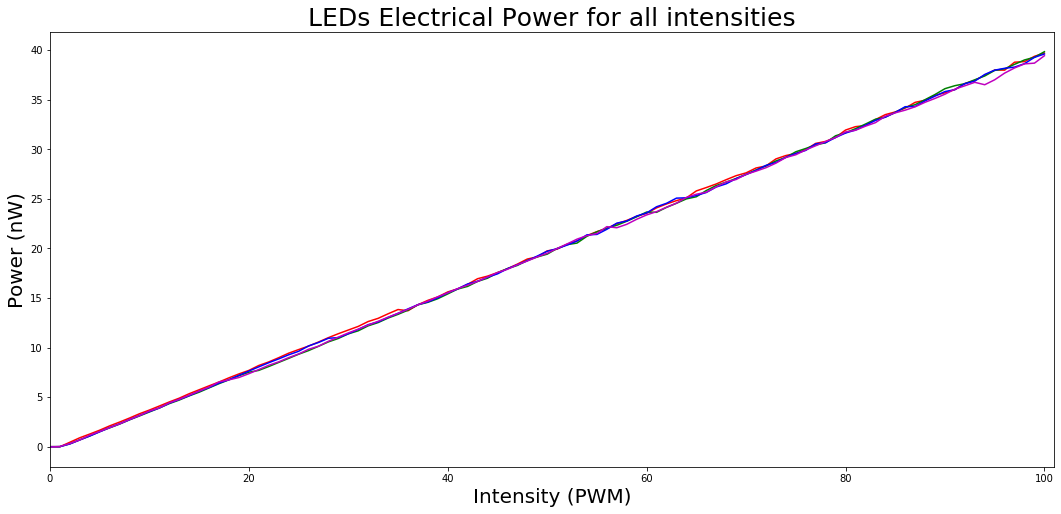

In [23]:
powermeter_red = pd.read_csv(Red_FileName, sep = ';',skiprows = Red_FirstRecording, header = None, names = ['number','date','time','power','irradiance'])
Power_red = np.asarray(powermeter_red.power)[:Steps]*(10**9)

powermeter_green = pd.read_csv(Green_FileName, sep = ';',skiprows = Green_FirstRecording, header = None, names = ['number','time','power','irradiance'])
Power_green = np.asarray(powermeter_green.power)[:Steps]*(10**9)

powermeter_blue= pd.read_csv(Blue_FileName, sep = ';',skiprows = Blue_FirstRecording, header = None, names = ['number','time','power','irradiance'])
Power_blue = np.asarray(powermeter_blue.power)[:Steps]*(10**9)

powermeter_uv = pd.read_csv(UV_FileName, sep = ';',skiprows = UV_FirstRecording, header = None, names = ['number','time','power','irradiance'])
Power_uv = np.asarray(powermeter_uv.power)[:Steps]*(10**9)

Power = np.zeros((nLED,Steps))
Power = [Power_red,Power_green,Power_blue,Power_uv]

y_Steps = np.arange(0,Steps,1)
fig,ax = plt.subplots(1,1,figsize = (18,8))

for iLED in range (nLED):
    ax.plot(y_Steps,Power[iLED],c=colour[iLED])
    
ax.set_title('LEDs Electrical Power for all intensities', fontsize = FigureTitleSize)
ax.set_xlabel('Intensity (PWM)', fontsize = FigureFontSize)
ax.set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax.set_xlim(0,101);

fig.savefig('Calibration_Figures//Powermeter Recordings.png')

## Plot LEDs power (nW) on their normalised spectra

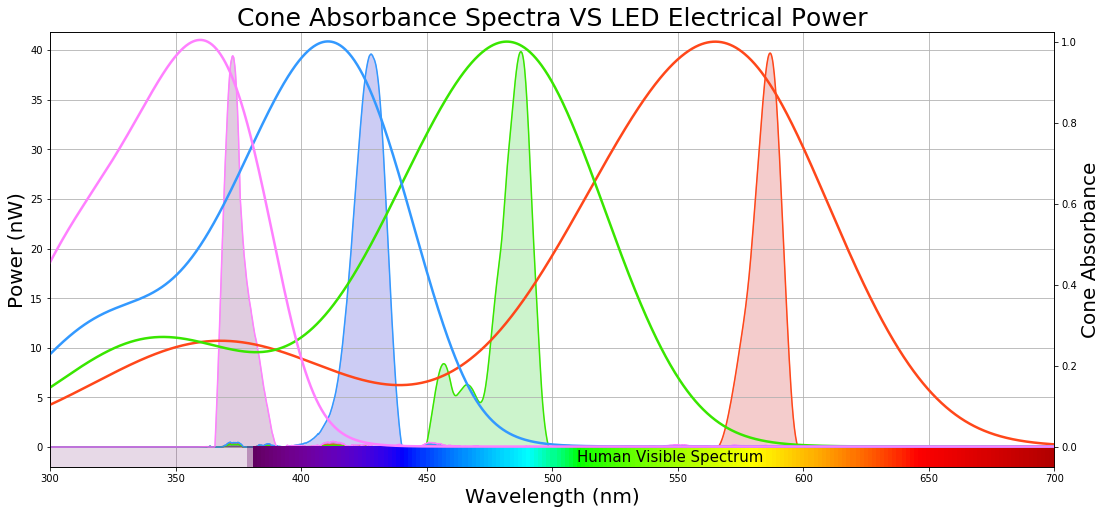

In [24]:
fig,ax = plt.subplots(1,1,figsize = (18,8))
ax2 = ax.twinx()

for i in range (nCone):
    ax2.plot(WvsX, Opsin[i], colors[i],linewidth=2.5)
    
for i in range (nLED):
    ax.plot(WvsX, LEDnormalised[i]*Power[i][-1], colors[i])
    ax.fill(WvsX, LEDnormalised[i]*Power[i][-1], c=RGBA[i])

ax.set_title('Cone Absorbance Spectra VS LED Electrical Power', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax2.set_ylabel('Cone Absorbance', fontsize = FigureFontSize)
ax.grid()

ax.set_xlim(SpectraRange)
ax2.set_ylim(-0.05,1.025)
ax2.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax2.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)

fig.savefig('Calibration_Figures//Powermeter Recordings Sumary.png')


***

# Determine Photo-Isomerisation Rates for all LED and Photoreceptor combinations

The number of photoisomerisation per photoreceptor produced by a flash is estimated as the product of the energy density (in photons.µm$^{-2}$) and the outer segment light collecting area, $Acollect$ (in µm$^{2}$)


## Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


***

## Determining the specific photon flux density $P_{E}(\lambda)$ for each LED


#### First, we convert the recorded Electrical Power (in $nW$) into Energy Flux, $P_{eFlux}$ (in $eV . s^{-1}$)  for each LED measurement

In [25]:
eV_per_J = 6.242E+18    

P_eflux = np.zeros((nLED,Steps))
for iLED in range (nLED):
    P_eflux[iLED,:] = np.multiply(Power[iLED]*10**-9,eV_per_J)
   
print('Red LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_eflux[0][-1] + ' eV.s-¹'  '\033[0m')
print('Green LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_eflux[1][-1] + ' eV.s-¹'  '\033[0m')
print('Blue LED Energy eflux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_eflux[2][-1] + ' eV.s-¹'  '\033[0m')
print('UV LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_eflux[3][-1] + ' eV.s-¹'  '\033[0m')

Red LED Energy flux at max intensity = 2.479e+11 eV.s-¹
Green LED Energy flux at max intensity = 2.487e+11 eV.s-¹
Blue LED Energy eflux at max intensity = 2.473e+11 eV.s-¹
UV LED Energy flux at max intensity = 2.462e+11 eV.s-¹


#### Then, we report the Energy Flux mesured for each LED recording to the normalised LED spectra


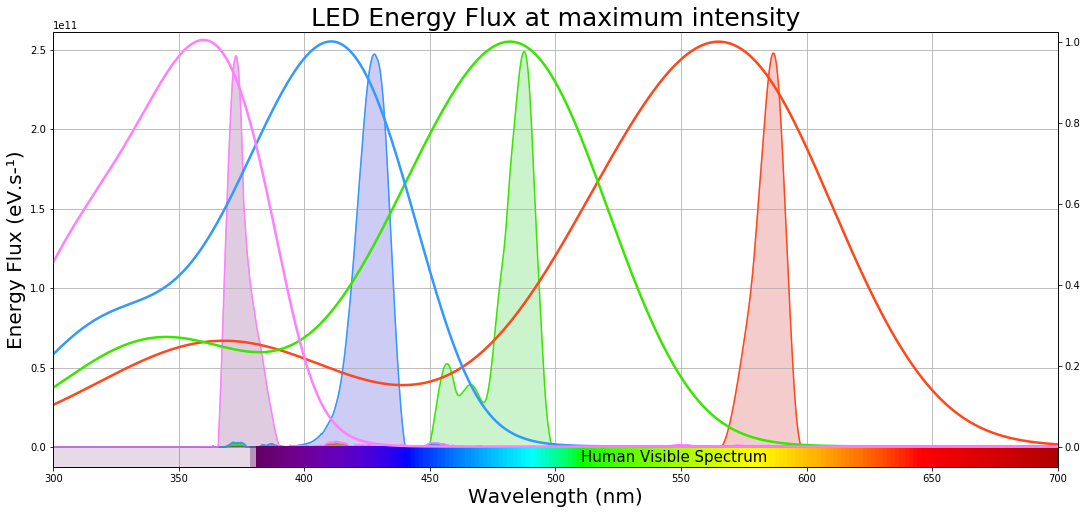

In [26]:
LEDint = np.zeros((nLED,len(WvsX)))
P_eFlux = np.zeros((nLED,Steps,len(WvsX)))

for iLED in range (nLED):     
    for PWM in range (Steps):    
        P_eFlux[iLED,PWM,:] = LEDNormalised[iLED] * P_eflux[iLED,PWM]
        P_eFlux[P_eFlux<0] = 0
        
fig,ax = plt.subplots(1,1,figsize = (18,8)) 
ax2 = ax.twinx()

for iLED in range(nLED):
    ax.plot(WvsX,P_eFlux[iLED][-1],colors[iLED]) 
    ax.fill(WvsX,P_eFlux[iLED][-1],c=RGBA[iLED]) 

for i in range (nCone):
    ax2.plot(WvsX, Opsin[i], colors[i],linewidth=2.5)

ax.set_title('LED Energy Flux at maximum intensity', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Energy Flux (eV.s-¹)', fontsize = FigureFontSize)
ax.grid()

ax.set_xlim(SpectraRange)
ax2.set_ylim(-0.05,1.025)
ax2.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax2.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)


fig.savefig('Calibration_Figures//LED Energy Flux.png');

***

#### Calculate the wavelength-dependent photon energy Q in $eV$
### $Q$ = $\frac{c . h}{\lambda}$ 
With:

$c$ the speed of light (299792458 m.s$^{-1}$)

$h$ the Planck's constant (4.135667.10$^{-15}$ eV.s)

$\lambda$ the wavelength (in m)

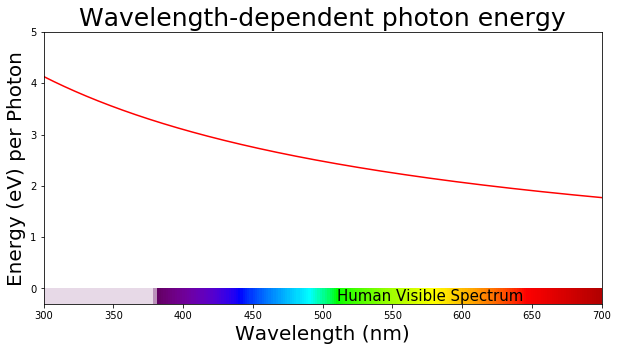

In [27]:
h = 4.135667E-15                         
c = 299792458  

Q = np.array((c*h/(WvsX *1E-9)), dtype=float)

fig,ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(WvsX, Q, color ='r')

ax.set_title('Wavelength-dependent photon energy', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Energy (eV) per Photon', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.25, 'Human Visible Spectrum', color ='black', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.3,5);

***

#### Now, we divide Energy Flux by the Photon Energy to get the Photon Flux $\phi$ (in $photons . s^{-1} $) for each LED recording 
### $\phi$ = $\frac{Peflux}{Q}$ 

In [28]:
Phi = np.zeros((nLED,Steps,len(WvsX)))

for iLED in range (nLED):
    for PWM in range (101):
        Phi[iLED,PWM] = np.divide(P_eFlux[iLED,PWM],Q)

toprint = [np.sum(Phi[i][-1]) for i in [0,1,2,3]]
print('Red LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprint[0] + ' photon.s-¹'  '\033[0m')
print('Green LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprint[1] + ' photon.s-¹'  '\033[0m')
print('Blue LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprint[2] + ' photon.s-¹'  '\033[0m')
print('UV LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprint[3] + ' photon.s-¹'  '\033[0m')

Red LED Photon Flux at max intensity = 7.45e+12 photon.s-¹
Green LED Photon Flux at max intensity = 7.59e+12 photon.s-¹
Blue LED Photon Flux at max intensity = 6.44e+12 photon.s-¹
UV LED Photon Flux at max intensity = 4.18e+12 photon.s-¹


#### Finally, we determine Photon Flux Density $P_{E}(\lambda)$ ($photons . s^{-1} . µm^{-2}$)
### $P_{E}(\lambda)$ = $\frac{\phi}{SensorArea}$

In [29]:
P_e = np.zeros((nLED,Steps,len(WvsX)))
P_E = np.zeros((nLED))

for iLED in range (nLED):
    P_e[iLED] = np.divide(Phi[iLED],SensorArea)
    P_E[iLED] = np.sum(P_e[iLED][-1])

print('Red LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_E[0] + ' photon/s/µ𝑚²' '\033[0m')
print('Green LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_E[1] + ' photon/s/µ𝑚²' '\033[0m')
print('Blue LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_E[2] + ' photon/s/µ𝑚²' '\033[0m')
print('UV LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_E[3] + ' photon/s/µ𝑚²' '\033[0m')

Red LED Photon Flux Density at max intensity = 1.05e+05 photon/s/µ𝑚²
Green LED Photon Flux Density at max intensity = 1.07e+05 photon/s/µ𝑚²
Blue LED Photon Flux Density at max intensity = 9.09e+04 photon/s/µ𝑚²
UV LED Photon Flux Density at max intensity = 5.9e+04 photon/s/µ𝑚²


***

## Determining the Light Collection Area of cone outer segments

 ### $A_{collect} = OSA . \gamma . 1-10^{\alpha . OSL}$ 

With

OSA the Outer Segment Area (in µm$^{2}$)

$\gamma$ the quantum efficiency of the opsin change

$\alpha$ the cone specific absorption coefficient (in µm$^{-1}$)

OSL the Outer Segment Length (in µm)


#### Set Lens and Cones physiological features

In [30]:
# Outer Segment Diameter for R,G,B & UV cones in µm. 
# Allison et al. 2004 - Visual pigment composition in zebrafish
OSD = np.asarray([2.4, 2.4, 2.8, 2.6], dtype = np.float64) 

# Outer Segment Area
OSA = np.pi*(OSD[:]/2)**2

# Outer Segment Length in µm 
# Branchek et al. 1984 - The development of photoreceptors in the zebrafish, Brachydanio rerio. I. Structure 
OSL = [10, 10, 7.6, 10]

# Specific Absorbance for R,G,B & UV opsins in µm-1
# Allison et al. 2004 - Visual pigment composition in zebrafish
Alpha = [0.0073, 0.0063, 0.007, 0.0054] 

# Quantum efficiency of the opsin change (p(Photoisomerisation/Light being absorbed)) 
# Dartnall et al. 1967 - The photosensitivities of visual pigments in the presence of hydroxylamine
Gamma = 0.67

#### Determine the Specific Absorption Coefficient $1-10^{\alpha . OSL}$ 

Also known as the Specific Optical Density, it is defined as the fraction of light absorbed per infinitesimal unit length of photopigment. It depends only on the absorption properties of the photopigment.

In [31]:
Absorption_coef = np.zeros((nCone))
for iCone in range (nCone):
    Absorption_coef[iCone] = 1-(10**(-Alpha[iCone]*OSL[iCone]))

#### Calculate the Light Collection Area $A_{collect}$ = OSA . $\gamma$ . Absorption Coefficient 

In [32]:
A_Collect = np.zeros((nCone))
for iCone in range (nCone):
    A_Collect[iCone] = OSA[iCone] * Gamma * Absorption_coef[iCone]
print('Red Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[0],decimals=2)) +' µm²'  '\033[0m')
print('Green Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[1],decimals=2)) +' µm²'  '\033[0m')
print('Blue Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[2],decimals=2)) +' µm²'  '\033[0m')
print('UV Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[3],decimals=2)) +' µm²'  '\033[0m')

Red Photoreceptor Light Collection Area = 0.47 µm²
Green Photoreceptor Light Collection Area = 0.41 µm²
Blue Photoreceptor Light Collection Area = 0.48 µm²
UV Photoreceptor Light Collection Area = 0.42 µm²


***

### Now we can determine the Photon Flux for each LED on each Opsin

#### $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$    (in $photons . s^{-1}$)

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


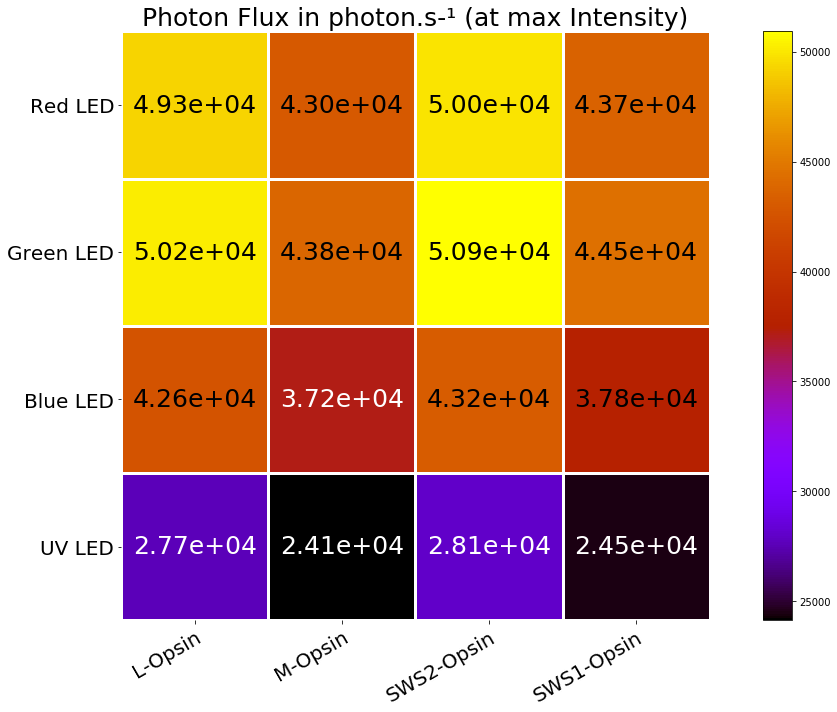

In [33]:
R_Ph = np.zeros((nCone,nLED))
for iCone in range (nCone):
    for iLED in range(nLED):
        R_Ph[iCone,iLED] = P_E[iLED] * A_Collect[iCone]
        
R_Ph = R_Ph.swapaxes(1,0)
vmaxRPh = np.amax(np.abs(R_Ph.reshape(-1)))
vminRPh = np.amin(np.abs(R_Ph.reshape(-1)))   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(R_Ph, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxRPh, vmin = vminRPh)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Photon Flux in photon.s-¹ (at max Intensity)', fontsize = FigureTitleSize)
fig.tight_layout()

***

## Finally, we determine the Photo-isomerisation state for each Opsin and LED combinations
### Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$
#### Where $S_{Act}(\lambda)$ corresponds to the Relative Co-Excitation matrix defined earlier

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


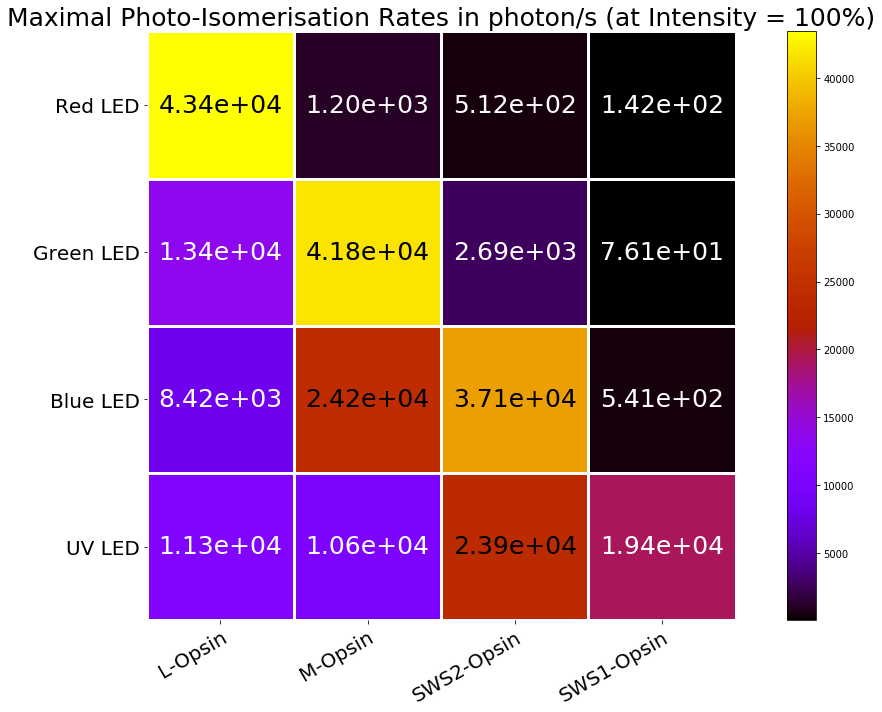

In [34]:
M1_Isomerisation = np.zeros((nCone,nLED))
for iCone in range(nCone):              # For each cone...
    for iLED in range(nLED):               # For each LED...
        M1_Isomerisation[iCone,iLED] = M1[iCone,iLED] * R_Ph[iCone,iLED]

M1_Isomerisation = M1_Isomerisation.swapaxes(1,0)
vmaxMiso = np.amax(np.abs(M1_Isomerisation.reshape(-1)))
vminMiso = np.amin(np.abs(M1_Isomerisation.reshape(-1)))   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(M1_Isomerisation, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxMiso, vmin = vminMiso)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Maximal Photo-Isomerisation Rates in photon/s (at Intensity = 100%)', fontsize = FigureTitleSize)
fig.tight_layout()

fig.savefig('Calibration_Figures//Photo-Isomerisation Rates Matrix.png');

## Plot the Maximal Photo-Isomerisation Rates (M_Iso) Matrix for each Opsin over its spectra 

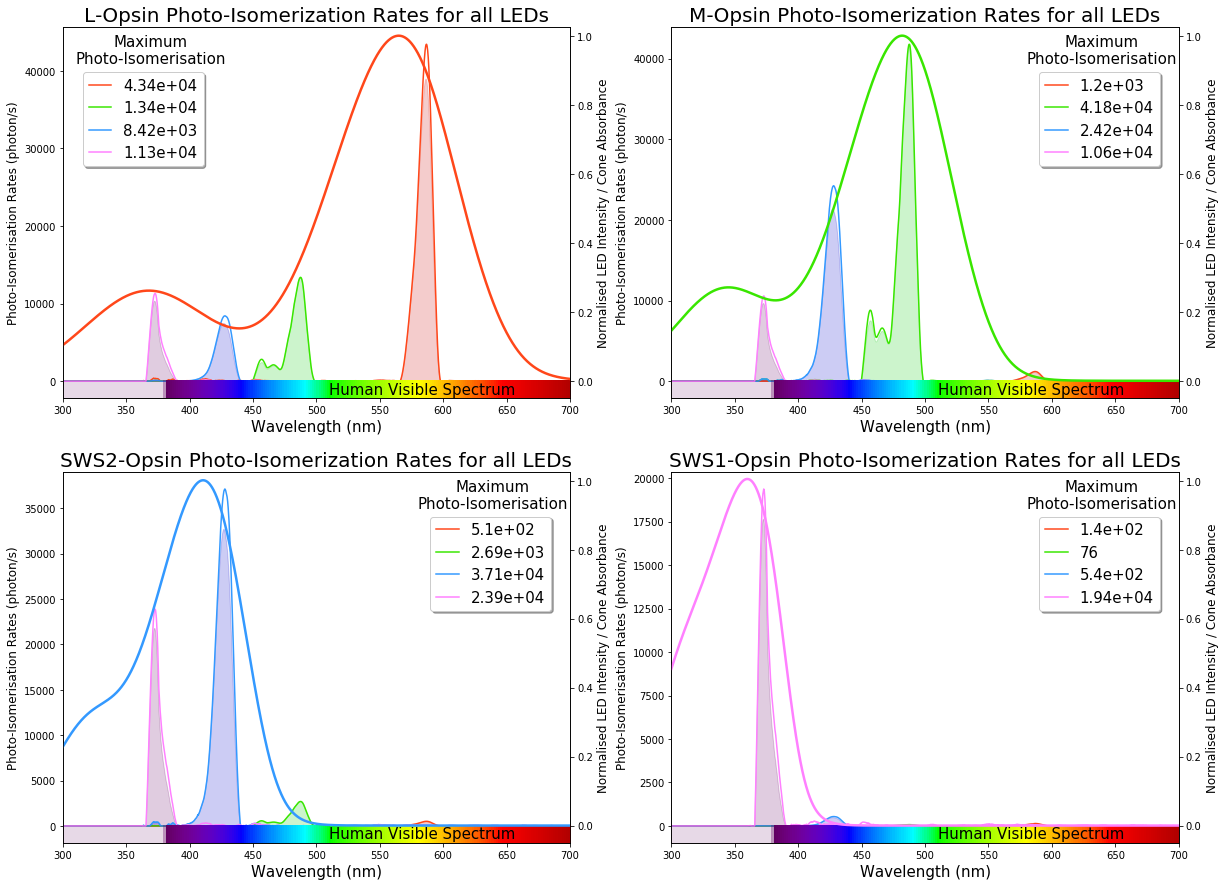

In [35]:
fig = plt.figure(figsize = (20,15)) 

ax0 = fig.add_subplot(221, sharex=None, sharey=None)
for i in range (nLED):
    ax0.plot(WvsX, LEDnormalised[i]*M1_Isomerisation[i][0], colors[i])
    ax0.fill(WvsX, LEDnormalised[i]*M1_Isomerisation[i][0]*Opsin[i], c=RGBA[i])
ax0.legend(("%.3g" %M1_Isomerisation[0][0], "%.3g" %M1_Isomerisation[1][0], "%.3g" %M1_Isomerisation[2][0], 
            "%.3g" %M1_Isomerisation[3][0]), shadow=True,loc=(0.04,0.625), handlelength=1.5, fontsize=15)
ax1 = ax0.twinx()
ax1.plot(WvsX, Opsin[0], colors[0],linewidth=2.5)
ax1.text(340,0.97, 'Maximum', fontsize=15);
ax1.text(310,0.92, 'Photo-Isomerisation', fontsize=15);
ax0.set_xlim(SpectraRange)
ax1.set_ylim(-0.05,1.025)
ax1.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax1.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax0.set_title('L-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax0.set_xlabel('Wavelength (nm)', fontsize = 15)
ax0.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax1.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12)



ax2 = fig.add_subplot(222, sharex=None, sharey=None)
for i in range (nLED):
    ax2.plot(WvsX, LEDnormalised[i]*M1_Isomerisation[i][1], colors[i])
    ax2.fill(WvsX, LEDnormalised[i]*M1_Isomerisation[i][1]*Opsin[i], c=RGBA[i])
ax2.legend(("%.3g" %M1_Isomerisation[0][1], "%.3g" %M1_Isomerisation[1][1], "%.3g" %M1_Isomerisation[2][1], 
            "%.3g" %M1_Isomerisation[3][1]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax3 = ax2.twinx()
ax3.plot(WvsX, Opsin[1], colors[1],linewidth=2.5)
ax3.text(610,0.97, 'Maximum', fontsize=15);
ax3.text(580,0.92, 'Photo-Isomerisation', fontsize=15);   
ax2.set_xlim(SpectraRange)
ax3.set_ylim(-0.05,1.025)
ax3.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax3.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax2.set_title('M-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax2.set_xlabel('Wavelength (nm)', fontsize = 15)
ax2.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax3.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);


ax4 = fig.add_subplot(223, sharex=None, sharey=None)
for i in range (nLED):
    ax4.plot(WvsX, LEDnormalised[i]*M1_Isomerisation[i][2], colors[i])
    ax4.fill(WvsX, LEDnormalised[i]*M1_Isomerisation[i][2]*Opsin[i], c=RGBA[i])
ax4.legend(("%.2g" %M1_Isomerisation[0][2], "%.3g" %M1_Isomerisation[1][2], "%.3g" %M1_Isomerisation[2][2], 
            "%.3g" %M1_Isomerisation[3][2]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax5 = ax4.twinx()
ax5.plot(WvsX, Opsin[2], colors[2],linewidth=2.5)
ax5.text(610,0.97, 'Maximum', fontsize=15);
ax5.text(580,0.92, 'Photo-Isomerisation', fontsize=15);
ax4.set_xlim(SpectraRange)
ax5.set_ylim(-0.05,1.025)
ax5.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax5.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax4.set_title('SWS2-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax4.set_xlabel('Wavelength (nm)', fontsize = 15)
ax4.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax5.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);


ax6 = fig.add_subplot(224, sharex=None, sharey=None)
for i in range (nLED):
    ax6.plot(WvsX, LEDnormalised[i]*M1_Isomerisation[i][3], colors[i])
    ax6.fill(WvsX, LEDnormalised[i]*M1_Isomerisation[i][3]*Opsin[i], c=RGBA[i])
ax6.legend(("%.2g" %M1_Isomerisation[0][3], "%.2g" %M1_Isomerisation[1][3], "%.2g" %M1_Isomerisation[2][3], 
            "%.3g" %M1_Isomerisation[3][3]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax7 = ax6.twinx()
ax7.plot(WvsX, Opsin[3], colors[3],linewidth=2.5)
ax7.text(610,0.97, 'Maximum', fontsize=15);
ax7.text(580,0.92, 'Photo-Isomerisation', fontsize=15);
ax6.set_xlim(SpectraRange)
ax7.set_ylim(-0.05,1.025)
ax7.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax7.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax6.set_title('SWS1-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax6.set_xlabel('Wavelength (nm)', fontsize = 15)
ax6.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax7.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);

fig.savefig('Calibration_Figures//Opsin-LED Photo-Isomerisation Rates.png');

## Plot the Maximal Photo-Isomerisation Rates (M_Iso) Matrix for each LED over its spectra 

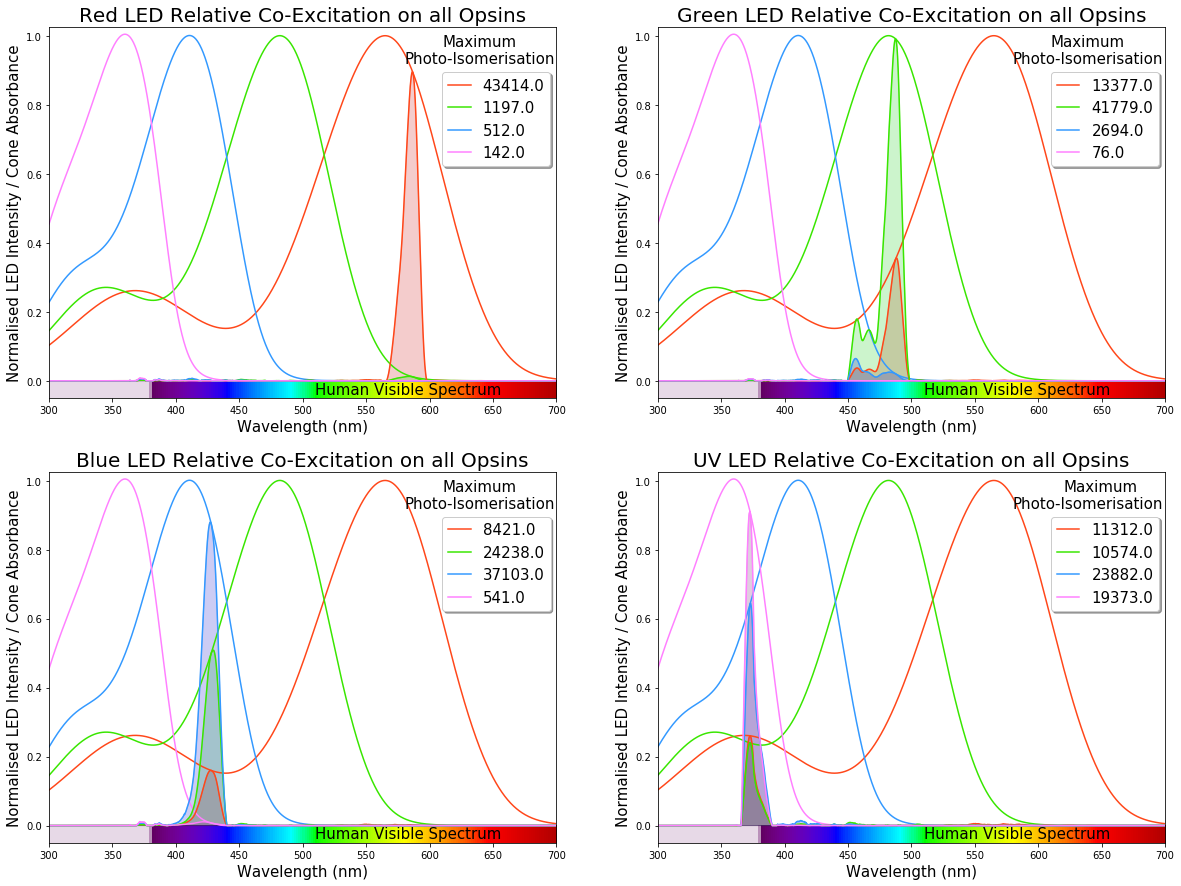

In [36]:
fig,ax = plt.subplots(2,2,figsize = (20,15))

for i in range (nCone):
    ax[0,0].plot(WvsX, Opsin[i], colors[i])
ax[0,0].legend((np.around(M1_Isomerisation[0][0]), np.around(M1_Isomerisation[0][1]), np.around(M1_Isomerisation[0][2]), np.around(M1_Isomerisation[0][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,0].text(610,0.97, 'Maximum', fontsize=15);
ax[0,0].text(580,0.92, 'Photo-Isomerisation', fontsize=15);  
for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[0]*Opsin[i], colors[i])
    ax[0,0].fill(WvsX, LEDnormalised[0]*Opsin[i], c=RGBA[i])
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('Red LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[0,1].plot(WvsX, Opsin[i], colors[i])
ax[0,1].legend((np.around(M1_Isomerisation[1][0]), np.around(M1_Isomerisation[1][1]), np.around(M1_Isomerisation[1][2]), np.around(M1_Isomerisation[1][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,1].text(610,0.97, 'Maximum', fontsize=15);
ax[0,1].text(580,0.92, 'Photo-Isomerisation', fontsize=15);  
for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[1]*Opsin[i], colors[i])
    ax[0,1].fill(WvsX, LEDnormalised[1]*Opsin[i], c=RGBA[i])
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('Green LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,0].plot(WvsX, Opsin[i], colors[i])
ax[1,0].legend((np.around(M1_Isomerisation[2][0]), np.around(M1_Isomerisation[2][1]), np.around(M1_Isomerisation[2][2]), np.around(M1_Isomerisation[2][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,0].text(610,0.97, 'Maximum', fontsize=15);
ax[1,0].text(580,0.92, 'Photo-Isomerisation', fontsize=15);
for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[2]*Opsin[i], colors[i])
    ax[1,0].fill(WvsX, LEDnormalised[2]*Opsin[i], c=RGBA[i])  
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('Blue LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,1].plot(WvsX, Opsin[i], colors[i])
ax[1,1].legend((np.around(M1_Isomerisation[3][0]), np.around(M1_Isomerisation[3][1]), np.around(M1_Isomerisation[3][2]), np.around(M1_Isomerisation[3][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,1].text(620,0.97, 'Maximum', fontsize=15);
ax[1,1].text(580,0.92, 'Photo-Isomerisation', fontsize=15);
for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[3]*Opsin[i], colors[i])
    ax[1,1].fill(WvsX, LEDnormalised[3]*Opsin[i], c=RGBA[i])  
ax[1,1].set_xlim(SpectraRange)
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,1].set_title('UV LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);


fig.savefig('Calibration_Figures//LED-Opsin Photo-Isomerisation Rates.png')

## Plot a Photo-Isomerisation Rates Summary

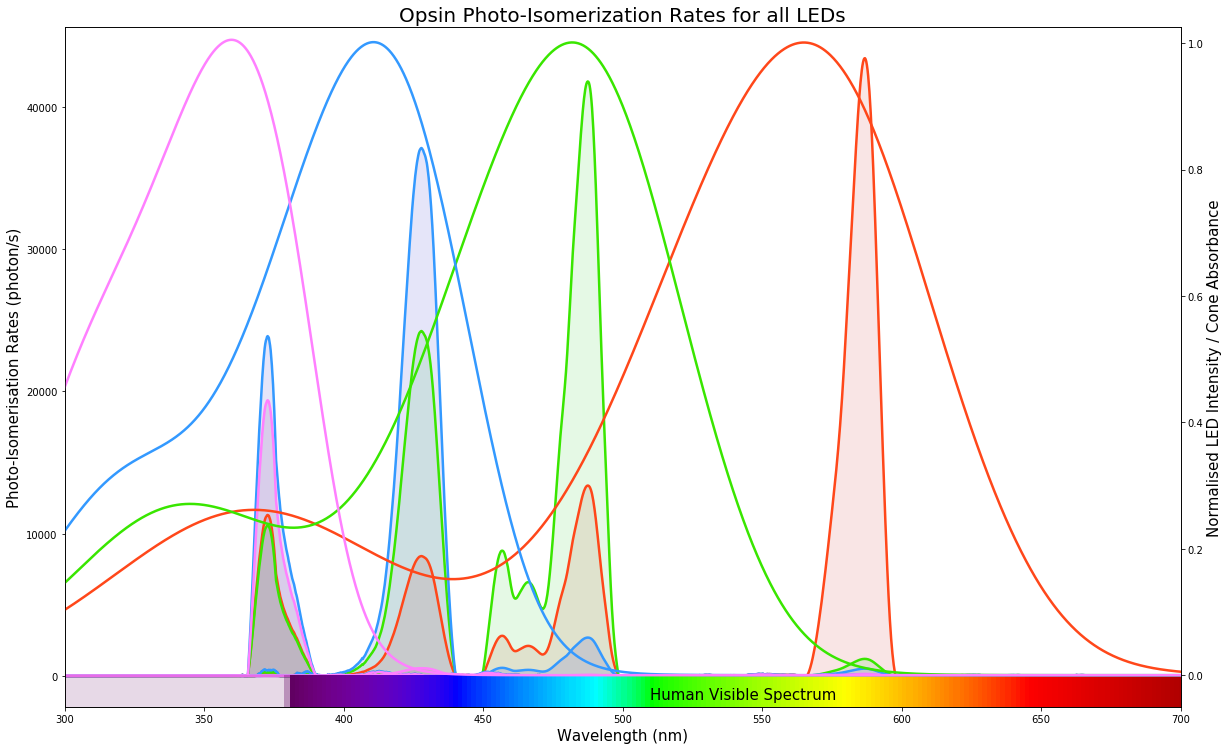

In [37]:
fig, ax = plt.subplots(figsize = (20,12.5)) 
ax1 = ax.twinx()

for j in range (nCone):
    for i in range (nLED):
        ax.plot(WvsX, LEDnormalised[i]*M1_Isomerisation[i][j], colors[j],linewidth=2.5)
        ax.fill(WvsX, LEDnormalised[i]*M1_Isomerisation[i][j], c=RGBA[j],alpha=0.10)
    
    ax1.plot(WvsX, Opsin[j], colors[j],linewidth=2.5)
    

ax.set_xlim(SpectraRange)
ax1.set_ylim(-0.05,1.025)
ax1.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax1.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax.set_title('Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax.set_xlabel('Wavelength (nm)', fontsize = 15)
ax.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 15)
ax1.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);

fig.savefig('Calibration_Figures//Photo-Isomerisation Rates Summary.png');

***

## Natural Stat' Settings
#### We previously calibrate the LEDs to display equal power across channels (40nW). From our field data we determined that in the zebrafish natural environment, the spectrum is obviously not uniform. Here we set up the LEDs power to correspond to the values recorded in the fish under water environment
##### Red LED = 6.35nW
##### Green LED = 3.0nW
##### Blue LED = 0.85nW
##### UV LED = 0.48nW

## Extract Powermeter Recording to determine the Electrical Power (in nW)

In [38]:
RedNat_FirstRecording = 22                                 # Set for the Red recording the first recording point
RedNat_LastRecording = RedNat_FirstRecording + Steps
GreenNat_FirstRecording = 22                               # Set for the Green recording the first recording point
GreenNat_LastRecording = GreenNat_FirstRecording + Steps
BlueNat_FirstRecording = 25                                # Set for the Blue recording the first recording point
BlueNat_LastRecording = BlueNat_FirstRecording + Steps
UVNat_FirstRecording = 23                                  # Set for the UV recording the first recording point
UVNat_LastRecording = UVNat_FirstRecording + Steps

RedNat_FileName = powerPath + 'Red_Nat.csv'                    # Import the Red recording (Red.csv has to be the name of the recording csv file)
GreenNat_FileName = powerPath + 'Green_Nat.csv'                # Import the Green recording (Red.csv has to be the name of the recording csv file)
BlueNat_FileName = powerPath + 'Blue_Nat.csv'                  # Import the Blue recording (Red.csv has to be the name of the recording csv file)
UVNat_FileName = powerPath + 'UV_Nat.csv'                      # Import the UV recording (Red.csv has to be the name of the recording csv file)

## Plot Energy readings for each LED 

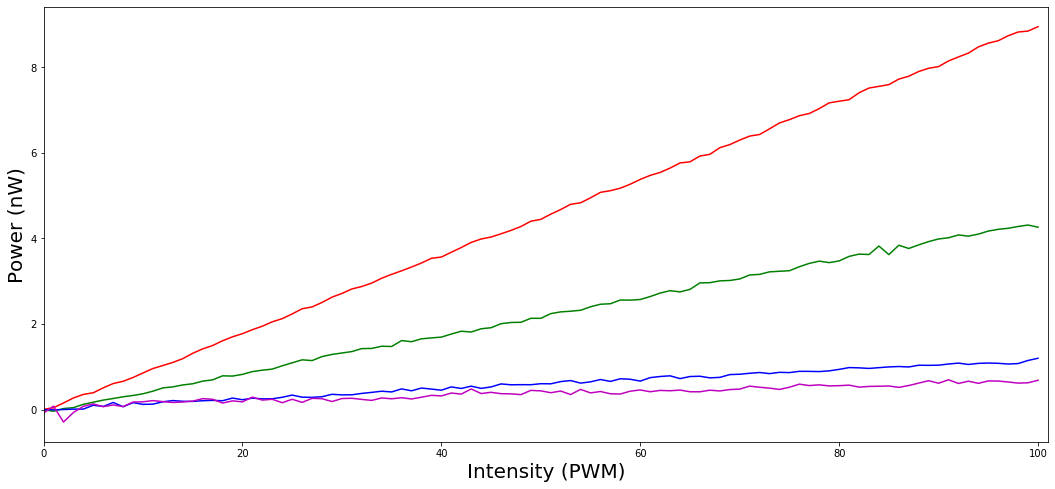

In [39]:
powermeter_rednat = pd.read_csv(RedNat_FileName, sep = ';',skiprows = RedNat_FirstRecording, header = None, names = ['number','time','power'])
Power_rednat = np.asarray(powermeter_rednat.power)[:Steps]*10**9

powermeter_greennat = pd.read_csv(GreenNat_FileName, sep = ';',skiprows = GreenNat_FirstRecording, header = None, names = ['number','time','power'])
Power_greennat = np.asarray(powermeter_greennat.power)[:Steps]*10**9

powermeter_bluenat= pd.read_csv(BlueNat_FileName, sep = ';',skiprows = BlueNat_FirstRecording, header = None, names = ['number','time','power'])
Power_bluenat = np.asarray(powermeter_bluenat.power)[:Steps]*10**9

powermeter_uvnat = pd.read_csv(UVNat_FileName, sep = ';',skiprows = UVNat_FirstRecording, header = None, names = ['number','time','power'])
Power_uvnat = np.asarray(powermeter_uvnat.power)[:Steps]*10**9

PowerNat = np.zeros((nLED,Steps))
PowerNat = (Power_rednat,Power_greennat,Power_bluenat,Power_uvnat)

y_Steps = np.arange(0,Steps,1)
fig,ax = plt.subplots(1,1,figsize = (18,8))

for iLED in range (nLED):
    ax.plot(y_Steps,PowerNat[iLED],c=colour[iLED])

ax.set_xlabel('Intensity (PWM)', fontsize = FigureFontSize)
ax.set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax.set_xlim(0,101);

fig.savefig('Calibration_Figures//Powermeter Recordings Nat-Stat.png');

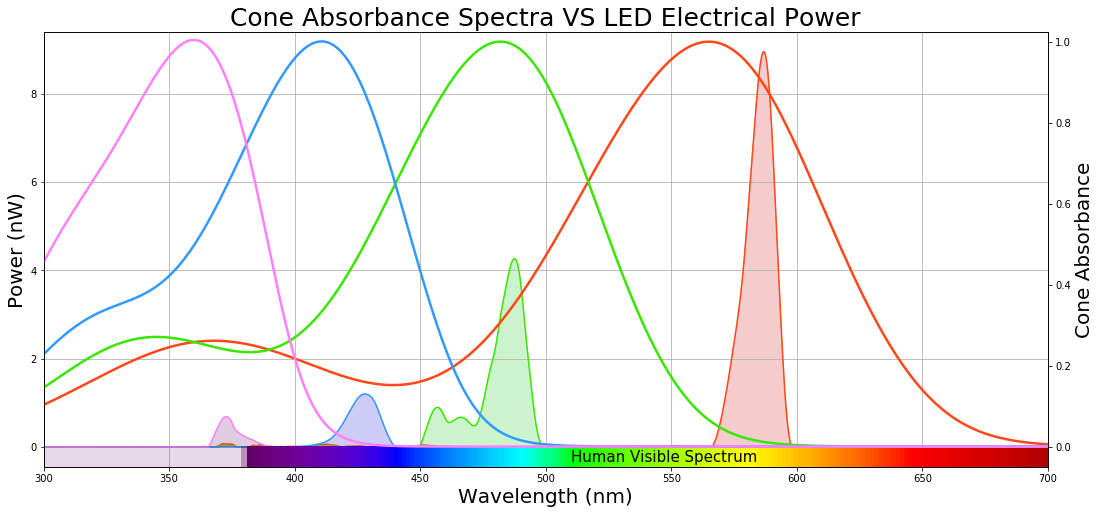

In [40]:
fig,ax = plt.subplots(1,1,figsize = (18,8))
ax2 = ax.twinx()

for i in range (nCone):
    ax2.plot(WvsX, Opsin[i], colors[i],linewidth=2.5)
    
for i in range (nLED):
    ax.plot(WvsX, LEDnormalised[i]*PowerNat[i][-1], colors[i])
    ax.fill(WvsX, LEDnormalised[i]*PowerNat[i][-1], c=RGBA[i])

ax.set_title('Cone Absorbance Spectra VS LED Electrical Power', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax2.set_ylabel('Cone Absorbance', fontsize = FigureFontSize)
ax.grid()

ax.set_xlim(SpectraRange)
ax2.set_ylim(-0.05,1.025)
ax2.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax2.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)

fig.savefig('Calibration_Figures//Powermeter Recordings Sumary Nat-Stat.png')

***

# Determine Photo-Isomerisation Rates for all LED and Photoreceptor combinations

The number of photoisomerisation per photoreceptor produced by a flash is estimated as the product of the energy density (in photons.µm$^{-2}$) and the outer segment light collecting area, $Acollect$ (in µm$^{2}$)


## Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


### Determining the specific photon flux density $P_{E}(\lambda)$ for each LED


#### First, we convert the recorded Electrical Power (in $nW$) into Energy Flux, $P_{eFlux}$ (in $eV . s^{-1}$)  for each LED measurement

In [41]:
P_efluxNat = np.zeros((nLED,Steps))
for iLED in range (nLED):
    P_efluxNat[iLED,:] = np.multiply(PowerNat[iLED]*10**-9,eV_per_J)
    
print('Red LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_efluxNat[0][-1] + ' eV.s-¹'  '\033[0m')
print('Green LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_efluxNat[1][-1] + ' eV.s-¹'  '\033[0m')
print('Blue LED Energy eflux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_efluxNat[2][-1] + ' eV.s-¹'  '\033[0m')
print('UV LED Energy flux at max intensity = ' + '\033[1m''\033[4m'  "%.4g" % P_efluxNat[3][-1] + ' eV.s-¹'  '\033[0m')

Red LED Energy flux at max intensity = 5.585e+10 eV.s-¹
Green LED Energy flux at max intensity = 2.661e+10 eV.s-¹
Blue LED Energy eflux at max intensity = 7.497e+09 eV.s-¹
UV LED Energy flux at max intensity = 4.286e+09 eV.s-¹


#### Then, we report the Energy Flux mesured for each LED recording to the normalised LED spectra


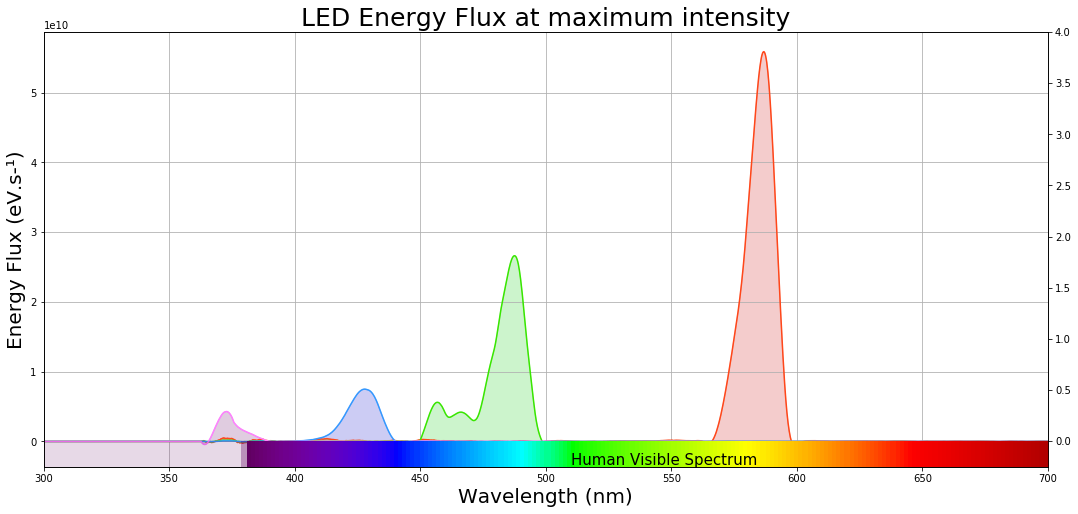

In [42]:
LEDint = np.zeros((nLED,len(WvsX)))
P_eFluxNat = np.zeros((nLED,Steps,len(WvsX)))

for iLED in range (nLED):     
    for PWM in range (Steps):    
        P_eFluxNat[iLED,PWM,:] = LEDNormalised[iLED] * P_efluxNat[iLED,PWM]
        
fig,ax = plt.subplots(1,1,figsize = (18,8))       
[ax.plot(WvsX,P_eFluxNat[iLED][-1],colors[iLED]) for iLED in range(nLED)];
[ax.fill(WvsX,P_eFluxNat[iLED][-1],c=RGBA[iLED]) for iLED in range(nLED)];

ax.set_title('LED Energy Flux at maximum intensity', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Energy Flux (eV.s-¹)', fontsize = FigureFontSize)
ax2 = ax.twinx()
ax2.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax2.text(510, -0.225, 'Human Visible Spectrum', color ='black', fontsize=15)
ax.set_xlim(SpectraRange)
ax2.set_ylim(-0.25,4)
ax.grid()

fig.savefig('Calibration_Figures//LED Energy Flux Nat-Stat.png');

***

#### Now, we divide Energy Flux by the Photon Energy to get the Photon Flux $\phi$ (in $photons . s^{-1} $) for each LED recording 
### $\phi$ = $\frac{Peflux}{Q}$ 

In [43]:
Phi_Nat = np.zeros((nLED,Steps,len(WvsX)))

for iLED in range (nLED):
    for PWM in range (101):
        Phi_Nat[iLED,PWM] = np.divide(P_eFluxNat[iLED,PWM],Q)

toprintnat = [np.sum(Phi_Nat[i][-1]) for i in [0,1,2,3]]
print('Red LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprintnat[0] + ' photon.s-¹'  '\033[0m')
print('Green LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprintnat[1] + ' photon.s-¹'  '\033[0m')
print('Blue LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprintnat[2] + ' photon.s-¹'  '\033[0m')
print('UV LED Photon Flux at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % toprintnat[3] + ' photon.s-¹'  '\033[0m')

Red LED Photon Flux at max intensity = 1.66e+12 photon.s-¹
Green LED Photon Flux at max intensity = 8.06e+11 photon.s-¹
Blue LED Photon Flux at max intensity = 1.93e+11 photon.s-¹
UV LED Photon Flux at max intensity = 7.03e+10 photon.s-¹


#### Finally, we determine Photon Flux Density $P_{E}(\lambda)$ ($photons . s^{-1} . µm^{-2}$)
### $P_{E}(\lambda)$ = $\frac{\phi}{SensorArea}$

In [44]:
P_eNat = np.zeros((nLED,Steps,len(WvsX)))
P_ENat = np.zeros((nLED))

for iLED in range (nLED):
    P_eNat[iLED] = np.divide(Phi_Nat[iLED],SensorArea)
    P_ENat[iLED] = np.sum(P_eNat[iLED][-1])

print('Red LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_ENat[0] + ' photon/s/µ𝑚²' '\033[0m')
print('Green LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_ENat[1] + ' photon/s/µ𝑚²' '\033[0m')
print('Blue LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_ENat[2] + ' photon/s/µ𝑚²' '\033[0m')
print('UV LED Photon Flux Density at max intensity = ' + '\033[1m''\033[4m'  "%.3g" % P_ENat[3] + ' photon/s/µ𝑚²' '\033[0m')

Red LED Photon Flux Density at max intensity = 2.35e+04 photon/s/µ𝑚²
Green LED Photon Flux Density at max intensity = 1.14e+04 photon/s/µ𝑚²
Blue LED Photon Flux Density at max intensity = 2.73e+03 photon/s/µ𝑚²
UV LED Photon Flux Density at max intensity = 992 photon/s/µ𝑚²


***

### Now we can determine the Photon Flux for each LED on each Opsin

#### $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$    (in $photons . s^{-1}$)

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


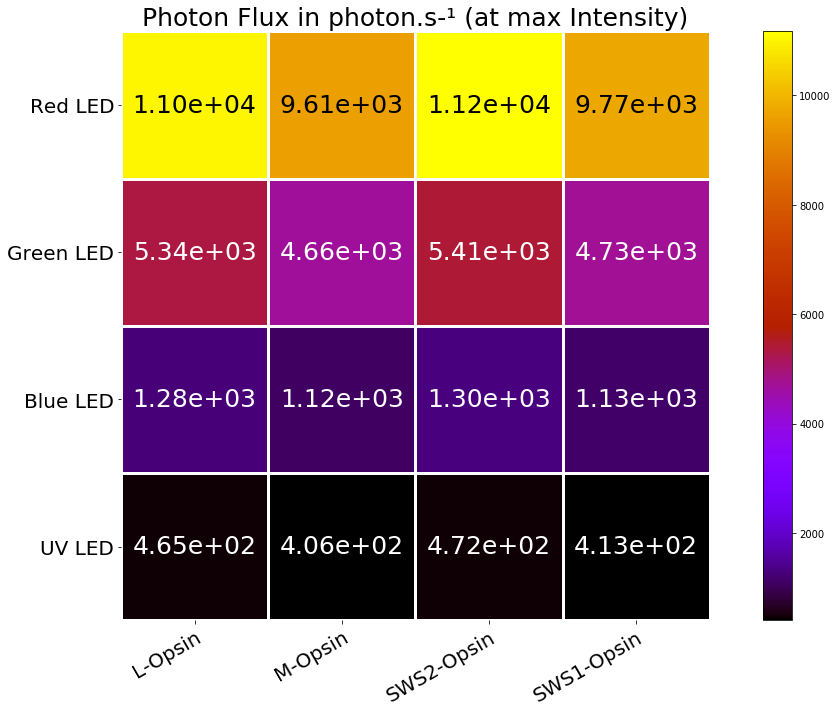

In [45]:
R_PhNat = np.zeros((nCone,nLED))
for iCone in range (nCone):
    for iLED in range(nLED):
        R_PhNat[iCone,iLED] = P_ENat[iLED] * A_Collect[iCone]
        
R_PhNat = R_PhNat.swapaxes(1,0)
vmaxRPhNat = np.amax(np.abs(R_PhNat.reshape(-1)))
vminRPhNat = np.amin(np.abs(R_PhNat.reshape(-1)))  
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(R_PhNat, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxRPhNat, vmin = vminRPhNat)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Photon Flux in photon.s-¹ (at max Intensity)', fontsize = FigureTitleSize)
fig.tight_layout()

***

## Finally, we determine the Photo-isomerisation state for each Opsin and LED combinations
### Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$
#### Where $S_{Act}(\lambda)$ corresponds to the Relative Co-Excitation matrix defined earlier

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


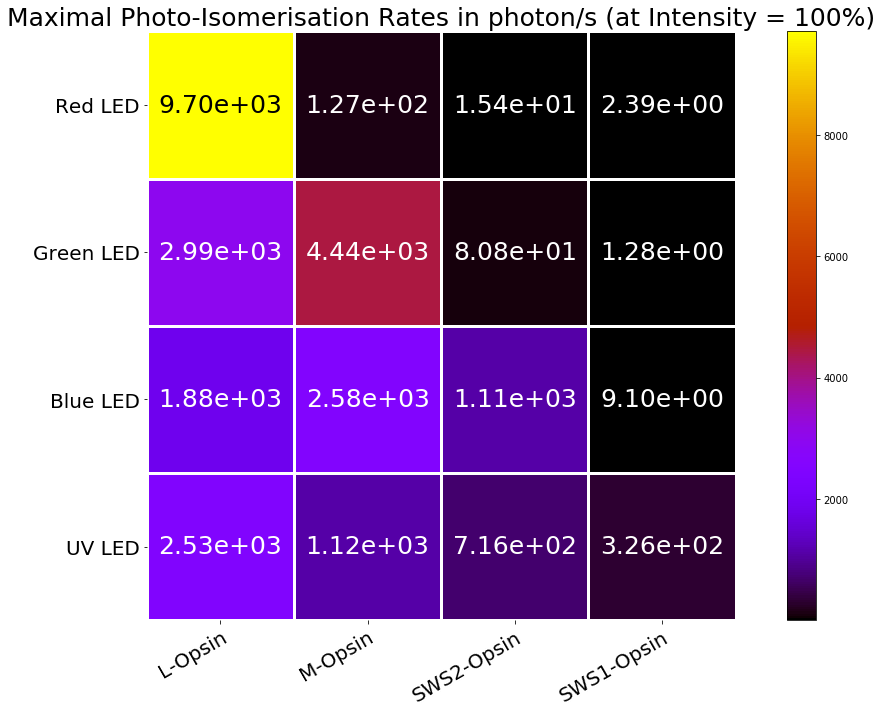

In [46]:
M1_IsomerisationNat = np.zeros((nCone,nLED))
for iCone in range(nCone):              # For each cone...
    for iLED in range(nLED):               # For each LED...
        M1_IsomerisationNat[iCone,iLED] = M1[iCone,iLED] * R_PhNat[iCone,iLED]

M1_IsomerisationNat = M1_IsomerisationNat.swapaxes(1,0)
vmaxMisoNat = np.amax(np.abs(M1_IsomerisationNat.reshape(-1)))
vminMisoNat = np.amin(np.abs(M1_IsomerisationNat.reshape(-1)))  
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(M1_IsomerisationNat, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxMisoNat, vmin = vminMisoNat)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Maximal Photo-Isomerisation Rates in photon/s (at Intensity = 100%)', fontsize = FigureTitleSize)
fig.tight_layout()

fig.savefig('Calibration_Figures//Photo-Isomerisation Rates Matrix Nat-Stat.png');

### Finally, determine the Photo-isomerisation state for each opsin and LED combinations

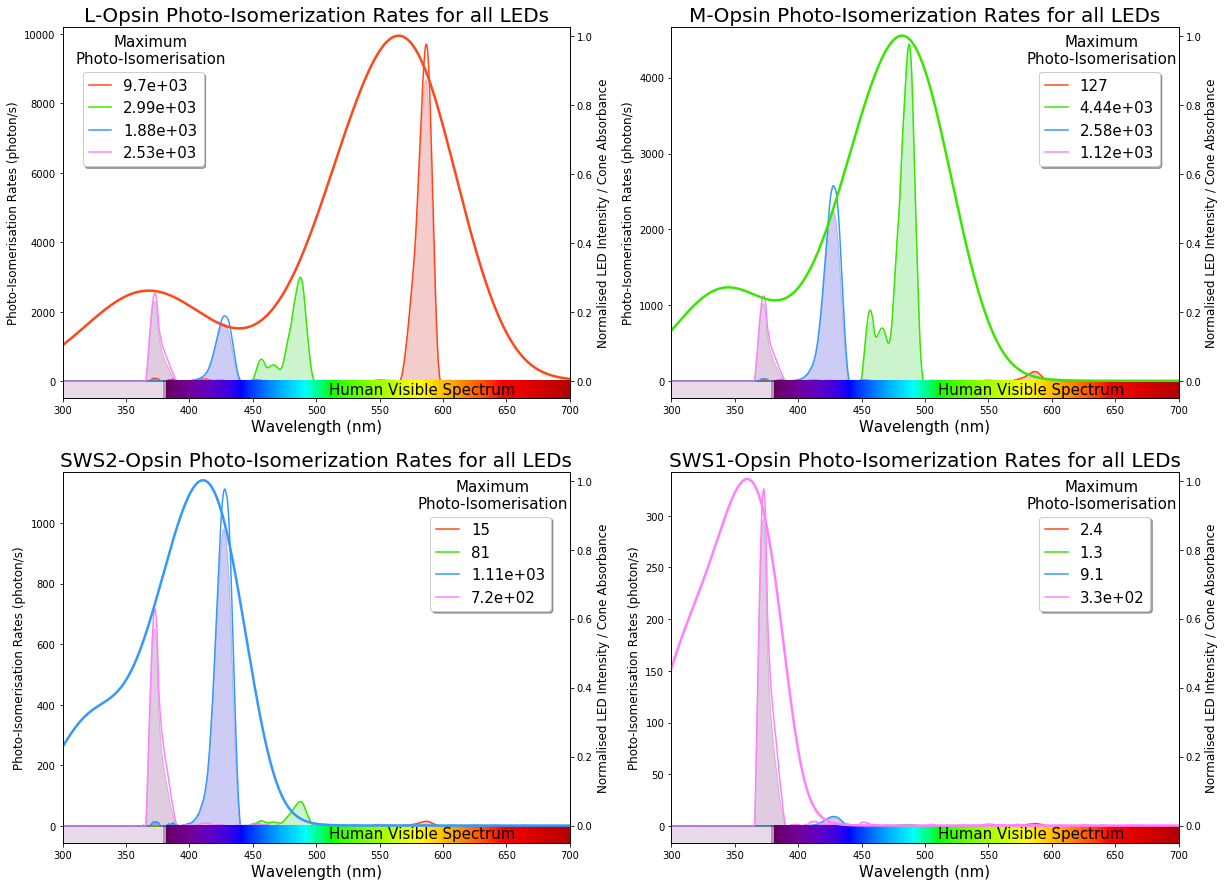

In [47]:
fig = plt.figure(figsize = (20,15)) 

ax0 = fig.add_subplot(221, sharex=None, sharey=None)
for i in range (nLED):
    ax0.plot(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][0], colors[i])
    ax0.fill(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][0]*Opsin[i], c=RGBA[i])
ax0.legend(("%.2g" %M1_IsomerisationNat[0][0], "%.3g" %M1_IsomerisationNat[1][0], "%.3g" %M1_IsomerisationNat[2][0], 
            "%.3g" %M1_IsomerisationNat[3][0]), shadow=True,loc=(0.04,0.625), handlelength=1.5, fontsize=15)
ax1 = ax0.twinx()
ax1.plot(WvsX, Opsin[0], colors[0],linewidth=2.5)
ax1.text(340,0.97, 'Maximum', fontsize=15);
ax1.text(310,0.92, 'Photo-Isomerisation', fontsize=15);
ax0.set_xlim(SpectraRange)
ax1.set_ylim(-0.05,1.025)
ax1.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax1.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax0.set_title('L-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax0.set_xlabel('Wavelength (nm)', fontsize = 15)
ax0.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax1.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12)



ax2 = fig.add_subplot(222, sharex=None, sharey=None)
for i in range (nLED):
    ax2.plot(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][1], colors[i])
    ax2.fill(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][1]*Opsin[i], c=RGBA[i])
ax2.legend(("%.3g" %M1_IsomerisationNat[0][1], "%.3g" %M1_IsomerisationNat[1][1], "%.3g" %M1_IsomerisationNat[2][1], 
            "%.3g" %M1_IsomerisationNat[3][1]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax3 = ax2.twinx()
ax3.plot(WvsX, Opsin[1], colors[1],linewidth=2.5)
ax3.text(610,0.97, 'Maximum', fontsize=15);
ax3.text(580,0.92, 'Photo-Isomerisation', fontsize=15);   
ax2.set_xlim(SpectraRange)
ax3.set_ylim(-0.05,1.025)
ax3.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax3.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax2.set_title('M-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax2.set_xlabel('Wavelength (nm)', fontsize = 15)
ax2.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax3.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);


ax4 = fig.add_subplot(223, sharex=None, sharey=None)
for i in range (nLED):
    ax4.plot(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][2], colors[i])
    ax4.fill(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][2]*Opsin[i], c=RGBA[i])
ax4.legend(("%.2g" %M1_IsomerisationNat[0][2], "%.2g" %M1_IsomerisationNat[1][2], "%.3g" %M1_IsomerisationNat[2][2], 
            "%.2g" %M1_IsomerisationNat[3][2]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax5 = ax4.twinx()
ax5.plot(WvsX, Opsin[2], colors[2],linewidth=2.5)
ax5.text(610,0.97, 'Maximum', fontsize=15);
ax5.text(580,0.92, 'Photo-Isomerisation', fontsize=15);
ax4.set_xlim(SpectraRange)
ax5.set_ylim(-0.05,1.025)
ax5.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax5.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax4.set_title('SWS2-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax4.set_xlabel('Wavelength (nm)', fontsize = 15)
ax4.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax5.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);


ax6 = fig.add_subplot(224, sharex=None, sharey=None)
for i in range (nLED):
    ax6.plot(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][3], colors[i])
    ax6.fill(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][3]*Opsin[i], c=RGBA[i])
ax6.legend(("%.2g" %M1_IsomerisationNat[0][3], "%.2g" %M1_IsomerisationNat[1][3], "%.2g" %M1_IsomerisationNat[2][3], 
            "%.2g" %M1_IsomerisationNat[3][3]), shadow=True,loc=(0.725, 0.625), handlelength=1.5, fontsize=15)
ax7 = ax6.twinx()
ax7.plot(WvsX, Opsin[3], colors[3],linewidth=2.5)
ax7.text(610,0.97, 'Maximum', fontsize=15);
ax7.text(580,0.92, 'Photo-Isomerisation', fontsize=15);
ax6.set_xlim(SpectraRange)
ax7.set_ylim(-0.05,1.025)
ax7.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax7.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax6.set_title('SWS1-Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax6.set_xlabel('Wavelength (nm)', fontsize = 15)
ax6.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 12)
ax7.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 12);

fig.savefig('Calibration_Figures//Opsin-LED Photo-Isomerisation Rates Nat-Stat.png');

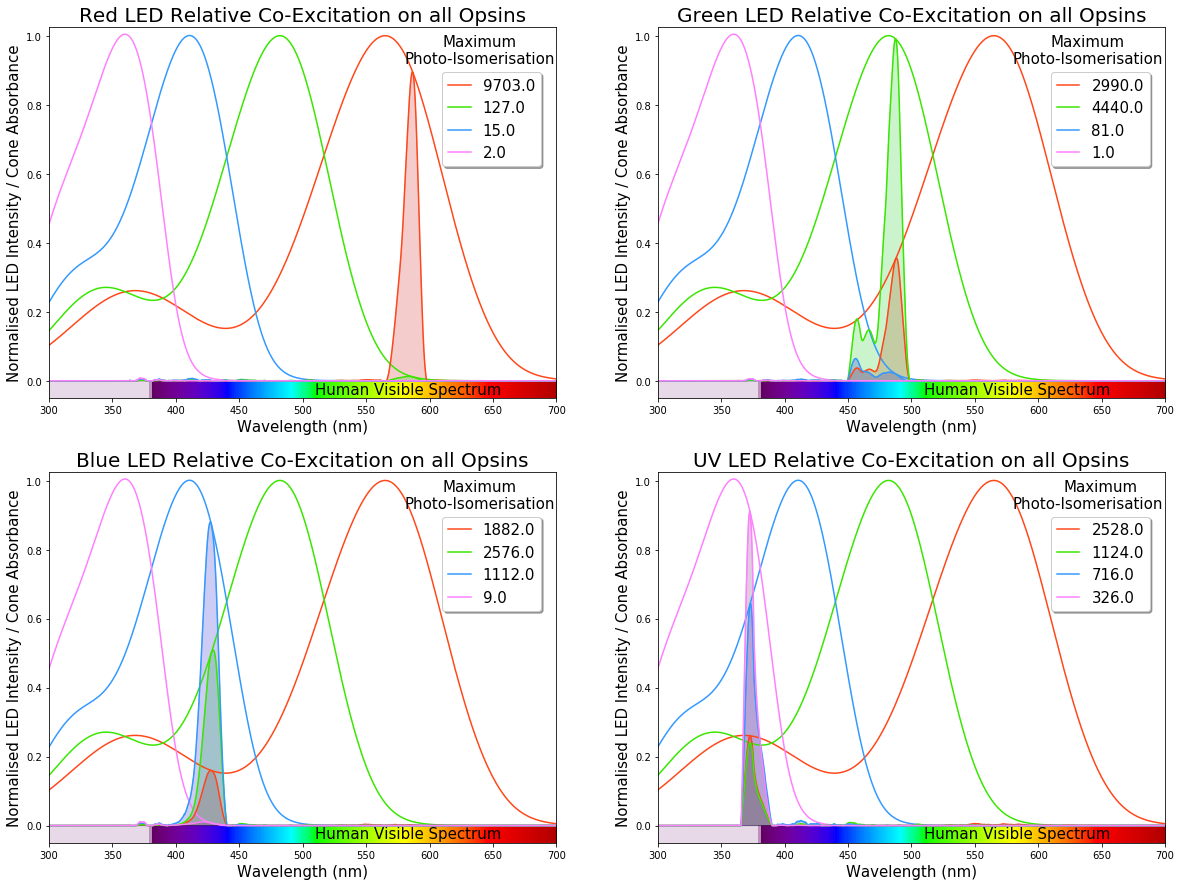

In [48]:
fig,ax = plt.subplots(2,2,figsize = (20,15))

for i in range (nCone):
    ax[0,0].plot(WvsX, Opsin[i], colors[i])
ax[0,0].legend((np.around(M1_IsomerisationNat[0][0]), np.around(M1_IsomerisationNat[0][1]), np.around(M1_IsomerisationNat[0][2]), np.around(M1_IsomerisationNat[0][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,0].text(610,0.97, 'Maximum', fontsize=15);
ax[0,0].text(580,0.92, 'Photo-Isomerisation', fontsize=15);  
for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[0]*Opsin[i], colors[i])
    ax[0,0].fill(WvsX, LEDnormalised[0]*Opsin[i], c=RGBA[i])
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('Red LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[0,1].plot(WvsX, Opsin[i], colors[i])
ax[0,1].legend((np.around(M1_IsomerisationNat[1][0]), np.around(M1_IsomerisationNat[1][1]), np.around(M1_IsomerisationNat[1][2]), np.around(M1_IsomerisationNat[1][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[0,1].text(610,0.97, 'Maximum', fontsize=15);
ax[0,1].text(580,0.92, 'Photo-Isomerisation', fontsize=15);  
for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[1]*Opsin[i], colors[i])
    ax[0,1].fill(WvsX, LEDnormalised[1]*Opsin[i], c=RGBA[i])
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('Green LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,0].plot(WvsX, Opsin[i], colors[i])
ax[1,0].legend((np.around(M1_IsomerisationNat[2][0]), np.around(M1_IsomerisationNat[2][1]), np.around(M1_IsomerisationNat[2][2]), np.around(M1_IsomerisationNat[2][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,0].text(610,0.97, 'Maximum', fontsize=15);
ax[1,0].text(580,0.92, 'Photo-Isomerisation', fontsize=15);
for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[2]*Opsin[i], colors[i])
    ax[1,0].fill(WvsX, LEDnormalised[2]*Opsin[i], c=RGBA[i])  
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('Blue LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,1].plot(WvsX, Opsin[i], colors[i])
ax[1,1].legend((np.around(M1_IsomerisationNat[3][0]), np.around(M1_IsomerisationNat[3][1]), np.around(M1_IsomerisationNat[3][2]), np.around(M1_IsomerisationNat[3][3])),
               shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=15)
ax[1,1].text(620,0.97, 'Maximum', fontsize=15);
ax[1,1].text(580,0.92, 'Photo-Isomerisation', fontsize=15);
for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[3]*Opsin[i], colors[i])
    ax[1,1].fill(WvsX, LEDnormalised[3]*Opsin[i], c=RGBA[i])  
ax[1,1].set_xlim(SpectraRange)
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,1].set_title('UV LED Relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);


fig.savefig('Calibration_Figures//LED-Opsin Photo-Isomerisation Rates Nat-Stat.png');

## Finally plot the Nat Stat Photo-Isomerisation Rate Summary

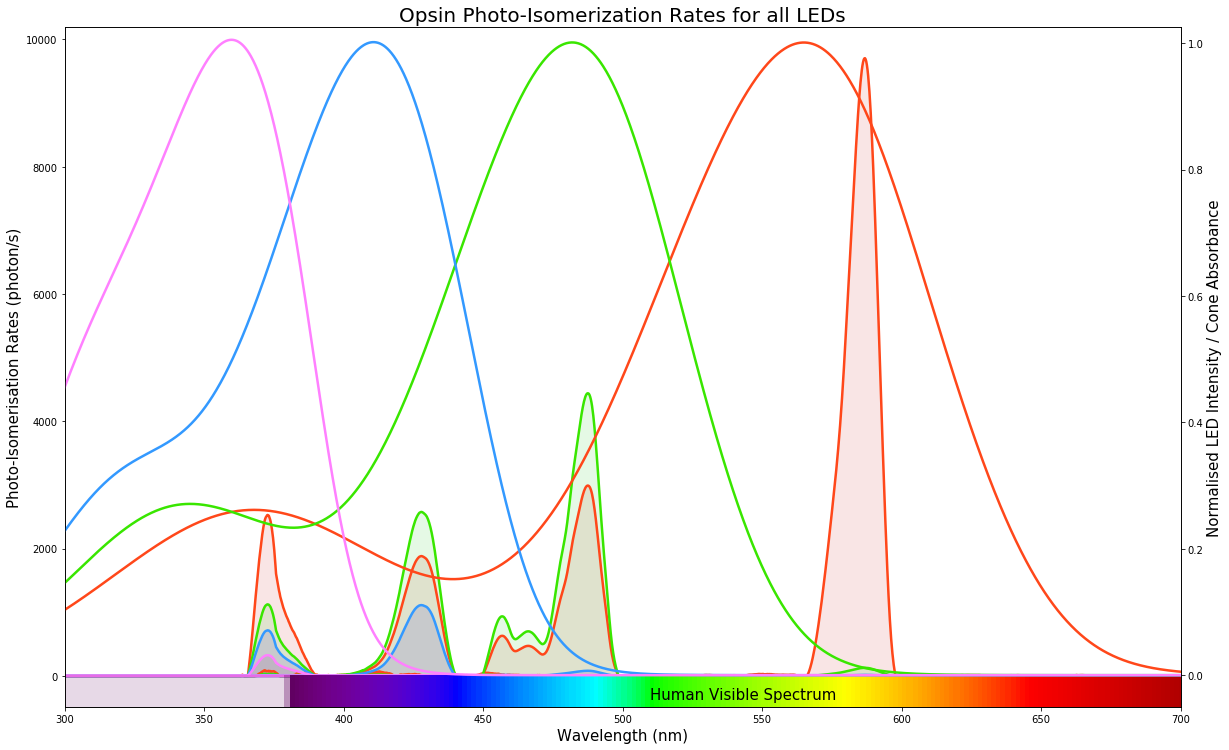

In [49]:
fig, ax = plt.subplots(figsize = (20,12.5)) 
ax1 = ax.twinx()

for j in range (nCone):
    for i in range (nLED):
        ax.plot(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][j], colors[j],linewidth=2.5)
        ax.fill(WvsX, LEDnormalised[i]*M1_IsomerisationNat[i][j], c=RGBA[j],alpha=0.10)
    
    ax1.plot(WvsX, Opsin[j], colors[j],linewidth=2.5)
    

ax.set_xlim(SpectraRange)
ax1.set_ylim(-0.05,1.025)
ax1.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax1.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax.set_title('Opsin Photo-Isomerization Rates for all LEDs', fontsize = 20)
ax.set_xlabel('Wavelength (nm)', fontsize = 15)
ax.set_ylabel('Photo-Isomerisation Rates (photon/s)', fontsize = 15)
ax1.set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);

fig.savefig('Calibration_Figures//Photo-Isomerisation Rates Summary Nat-Stat.png');

***

***

## Silent Substitution Protocol
This protocol is based on [Estevez et al.](https://www.ncbi.nlm.nih.gov/pubmed/7112962)(The "silent substitution" method in visual research, 1982), where one type of photoreceptor is selectively stimnulated by presenting a steady excitation to all other photoreceptor types using a counteracting stimulus, hencefore virtually silencing their pigment. This allows for instance the investigation of the role of individual photoreceptor types in visual processing

This script detailed a protocol for generating opsin-isolating stimuli that account for the cross-activation of zebrafish opsins by the LEDs. 

"When two lights with physically different spectral distributions form a complete visual match (metamers), they are exactly equal for the all cone pigments and, therefore, completely interchangeable for the visual system. If one of these two lights was substituted for the other, the visual system would not be able to detect the change.

Here, one opsin type is selectively stimulated by presenting a scaled, counterphase version of the stimulus to all other opsin types. 

### We begin by writing in matrix notation the three linear relations between the stimuli r, g, b and uv and the total quantum catch produced in each of the cone pigments $S_{Cone/LED}$

### $$
\left(\begin{array}{cc} 
S_{Red}\\
S_{Green}\\
S_{Blue}\\
S_{UV}
\end{array}\right)
=
\left(\begin{array}{cc} 
S_{L/R} & S_{M/R} & S_{S/R} & S_{UV/R}\\
S_{L/G} & S_{M/G} & S_{S/G} & S_{UV/G}\\
S_{L/B} & S_{M/B} & S_{S/B} & S_{UV/B}\\
S_{L/UV} & S_{M/UV} & S_{S/UV} & S_{UV/UV}
\end{array}\right)
x
\left(\begin{array}{cc} 
r\\
g\\
b\\
uv
\end{array}\right)
$$ 

#### Let's write the above equation in abbreviated form:
### $$
\left(\begin{array}{cc} 
S
\end{array}\right)
=
\left(\begin{array}{cc} 
M
\end{array}\right)
x
\left(\begin{array}{cc} 
C
\end{array}\right)
$$ 
#### Where:

#### S, the effective cone stimuli

#### M, the transform matrix

#### C, the colour mixture columns vector

#### If we call N the inverse matrix of M, then:
### $$
\left(\begin{array}{cc} 
C
\end{array}\right)
=
\left(\begin{array}{cc} 
N
\end{array}\right)
x
\left(\begin{array}{cc} 
S
\end{array}\right)
$$ 

### We notice that, within the limits imposed by the transformation M, one can choose to stimulate the four cone systems in some ratio by finding the corresponding values of r, g, b,uv solving the above equation. 

***

### First we generate the M Matrix which corresponds to the Maximal PhotoIsomerisation Rates Matrix defined earlier, but with a flux density of 1 $photon . s^{-1} . µm^{-2}$


### Photoisomerisation rate =  $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

#### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

#### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


#### Determining the Photon Flux   $R_{Ph}(\lambda)$ for $P_{E}(\lambda)$ = 1 $photon . s^{-1} . µm^{-2}$ for each LED

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


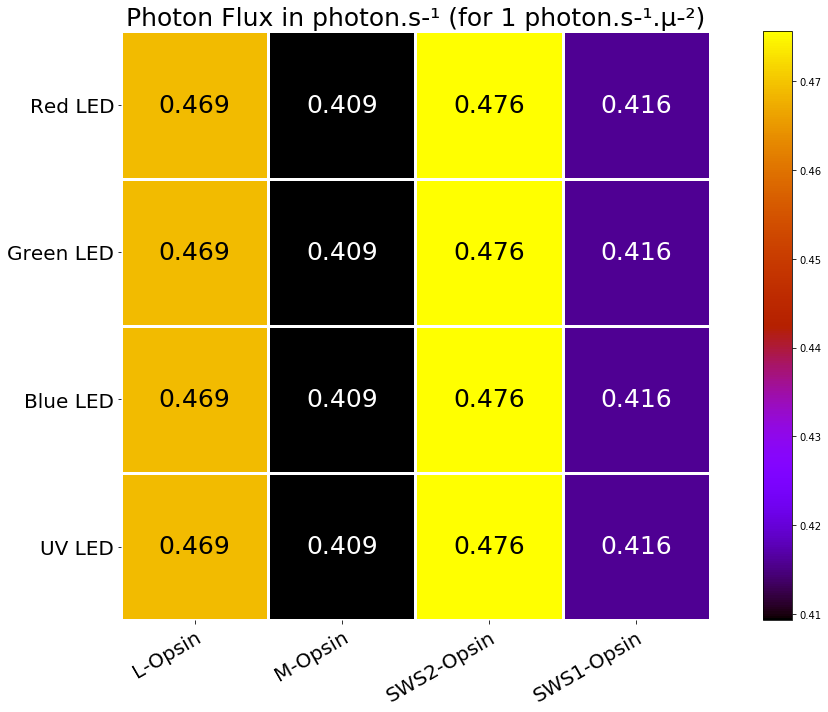

In [50]:
P_E1 = np.ones((4))

R_Ph1 = np.zeros((nCone,nLED))
for iCone in range (nCone):
    for iLED in range(nLED):
        R_Ph1[iCone,iLED] = P_E1[iLED] * A_Collect[iCone]
        
R_Ph1 = R_Ph1.swapaxes(1,0)
vmaxRPh1 = np.amax(np.abs(R_Ph1.reshape(-1)))
vminRPh1 = np.amin(np.abs(R_Ph1.reshape(-1)))   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(R_Ph1, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxRPh1, vmin = vminRPh1)
annotate_heatmap(im, valfmt="{x:.3f}", size=FigureFontSize+5)
ax.set_title('Photon Flux in photon.s-¹ (for 1 photon.s-¹.µ-²)', fontsize = FigureTitleSize)
fig.tight_layout()

#### M Matrix =  $\Sigma R_{Ph1}(\lambda) . S_{Act}(\lambda)$

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


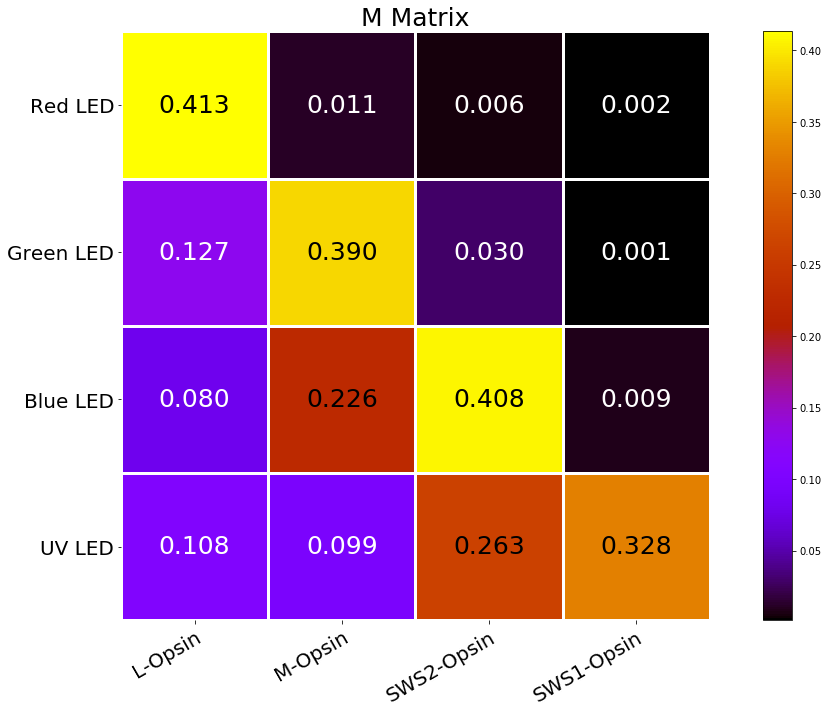

In [51]:
M_Matrix = np.zeros((nCone,nLED))
for iCone in range(nCone):              # For each cone...
    for iLED in range(nLED):               # For each LED...
        M_Matrix[iCone,iLED] = M1[iCone,iLED] * R_Ph1[iCone,iLED]

M_Matrix = M_Matrix.swapaxes(1,0)
vmaxM_Matrix = np.amax(np.abs(M_Matrix.reshape(-1)))
vminM_Matrix = np.amin(np.abs(M_Matrix.reshape(-1)))  
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(M_Matrix, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxM_Matrix, vmin = vminM_Matrix)
annotate_heatmap(im, valfmt="{x:.3f}", size=FigureFontSize+5)
ax.set_title('M Matrix', fontsize = FigureTitleSize)
fig.tight_layout()

### Now we generate the N Matrix ($M^{-1}$)

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


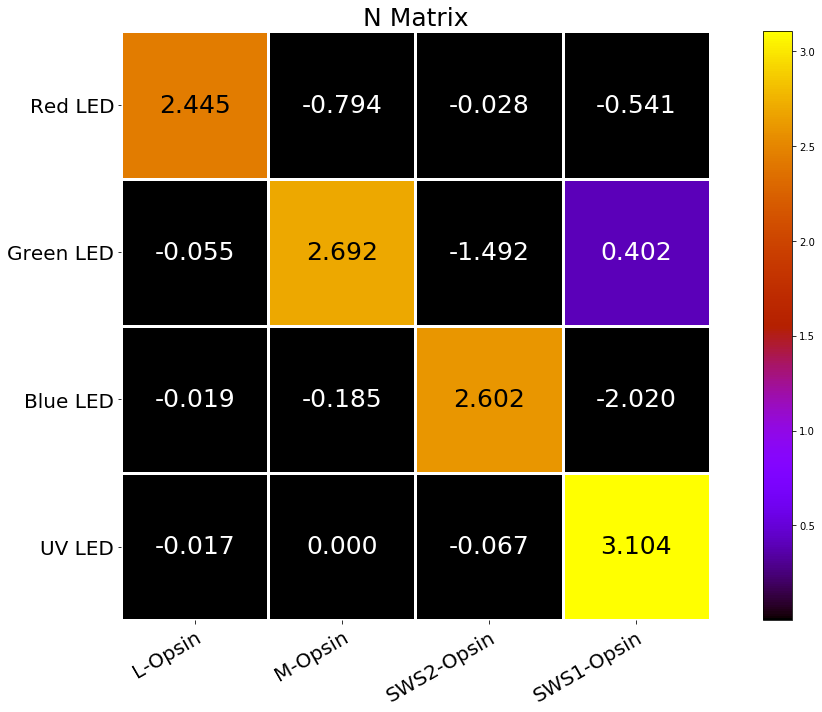

In [52]:
N_Matrix = np.linalg.inv(M_Matrix)

N_Matrix = N_Matrix.swapaxes(1,0)
vmaxN_Matrix = np.amax(np.abs(N_Matrix.reshape(-1)))
vminN_Matrix = np.amin(np.abs(N_Matrix.reshape(-1)))  
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(N_Matrix, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxN_Matrix, vmin = vminN_Matrix)
annotate_heatmap(im, valfmt="{x:.3f}", size=FigureFontSize+5)
ax.set_title('N Matrix', fontsize = FigureTitleSize)
fig.tight_layout()

***

### Now that we have the N Matrix for our system, we need to determine the effective cone stimuli (S)

Finally, we generate a normalised stimuli that the isolated opsin will be stimulated with (here a sine wave as example):
The other expected opsin response will be set to 0.5

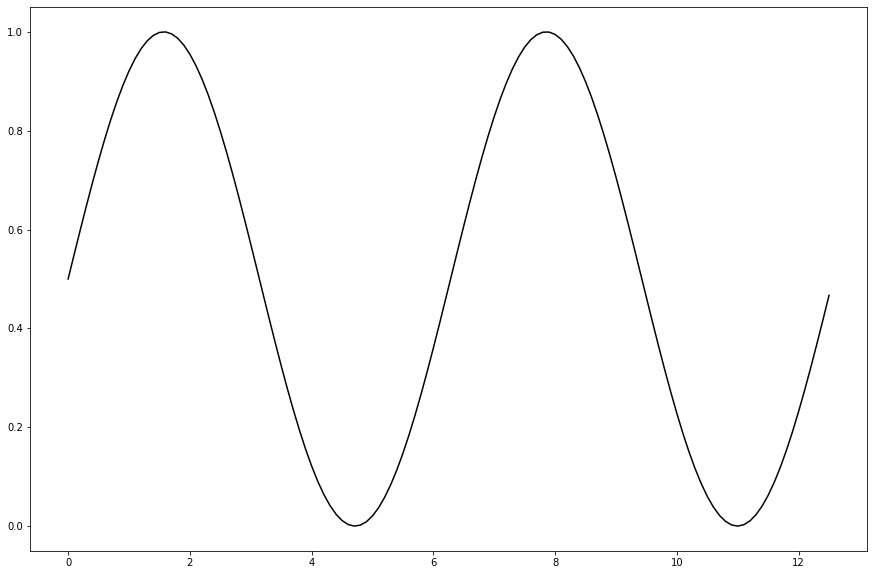

In [53]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

X_Stimulus = np.arange(0, 4*np.pi, 0.1)
A_Stimulus = (np.sin(X_Stimulus)+1)/2
ax.plot(X_Stimulus,A_Stimulus,'k');

***

## Isolating the L Cone

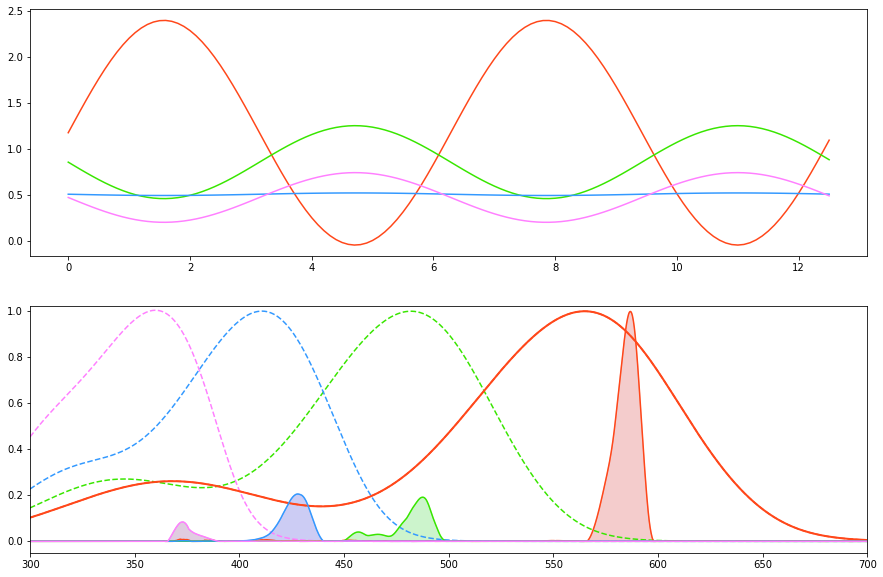

In [54]:
fig,ax = plt.subplots(2,1,figsize = FigureSize)

L_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    L_ratio = np.zeros((4))
    L_ratio[0] = vals[i]
    L_ratio[1] = 0.5
    L_ratio[2] = 0.5
    L_ratio[3] = 0.5
    L_Cone_isolation.append(L_ratio)
    
L_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = L_Cone_isolation[i]@N_Matrix
    L_LED_ratios.append(LED)
    
L_LED_ratios = np.stack(L_LED_ratios)

for i in range (nLED):   
    ax[0].plot(X_Stimulus,L_LED_ratios[:,i],color=colors[i])

for i in range (nCone):
    ax[1].plot(WvsX, Opsin[i], '--', c=colors[i])
ax[1].plot(WvsX, Opsin[0], colors[0],linewidth = 2)

L_Ratio = []
for i in range(nLED):
    l = L_LED_ratios[16][i]/np.nanmax((L_LED_ratios[16][0]))
    L_Ratio.append(l)
for i in range (nLED):
    ax[1].plot(WvsX, LEDnormalised[i]*L_Ratio[i], colors[i])
    ax[1].fill(WvsX, LEDnormalised[i]*L_Ratio[i], c=RGBA[i])
    
ax[1].set_ylim(-0.05,1.025)
ax[1].set_xlim(SpectraRange);

***

## Isolating the M Cone

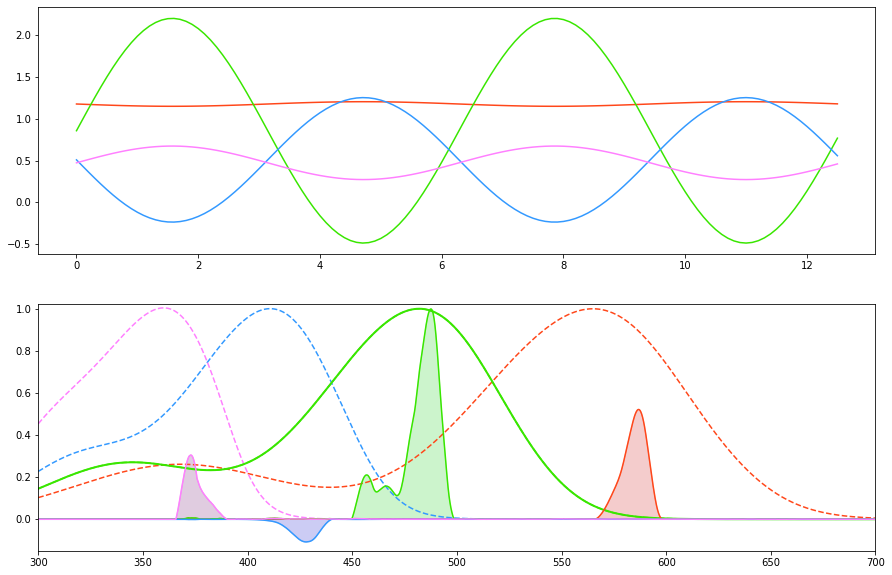

In [55]:
fig,ax = plt.subplots(2,1,figsize = FigureSize)

M_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    M_ratio = np.zeros((4))
    M_ratio[0] = 0.5
    M_ratio[1] = vals[i]
    M_ratio[2] = 0.5
    M_ratio[3] = 0.5
    M_Cone_isolation.append(M_ratio)
    
M_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = M_Cone_isolation[i]@N_Matrix
    M_LED_ratios.append(LED)
    
M_LED_ratios = np.stack(M_LED_ratios)

for i in range (nLED):   
    ax[0].plot(X_Stimulus,M_LED_ratios[:,i],color=colors[i])
    
for i in range (nCone):
    ax[1].plot(WvsX, Opsin[i], '--', c=colors[i])
    
M_Ratio = []
for i in range(nLED):
    m = M_LED_ratios[16][i]/np.nanmax((M_LED_ratios[16][1]))
    M_Ratio.append(m)
ax[1].plot(WvsX, Opsin[1], colors[1],linewidth = 2)
for i in range (nLED):
    ax[1].plot(WvsX, LEDnormalised[i]*M_Ratio[i], colors[i])
    ax[1].fill(WvsX, LEDnormalised[i]*M_Ratio[i], c=RGBA[i])
    
ax[1].set_ylim(-0.15,1.025)
ax[1].set_xlim(SpectraRange);

***

## Isolating the SWS2 Cone

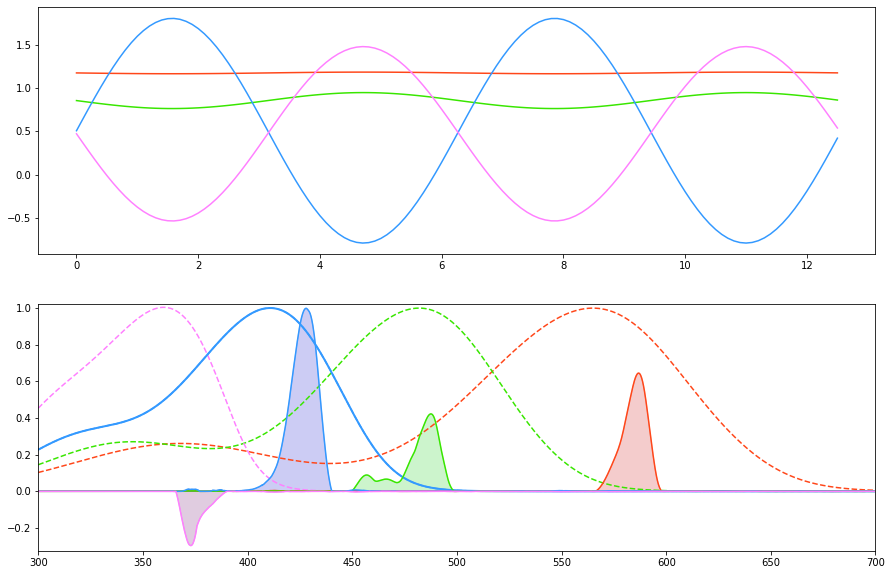

In [56]:
fig,ax = plt.subplots(2,1,figsize = FigureSize)

S_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    S_ratio = np.zeros((4))
    S_ratio[0] = 0.5
    S_ratio[1] = 0.5
    S_ratio[2] = vals[i]
    S_ratio[3] = 0.5
    S_Cone_isolation.append(S_ratio)
    
S_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = S_Cone_isolation[i]@N_Matrix
    S_LED_ratios.append(LED)
    
S_LED_ratios = np.stack(S_LED_ratios)

for i in range (nLED):   
    ax[0].plot(X_Stimulus,S_LED_ratios[:,i],color=colors[i])
    
for i in range (nCone):
    ax[1].plot(WvsX, Opsin[i], '--', c=colors[i])
ax[1].plot(WvsX, Opsin[2], colors[2],linewidth = 2)

S_Ratio = []
for i in range(nLED):
    s = S_LED_ratios[16][i]/np.nanmax((S_LED_ratios[16][2]))
    S_Ratio.append(s)
for i in range (nLED):
    ax[1].plot(WvsX, LEDnormalised[i]*S_Ratio[i], colors[i])
    ax[1].fill(WvsX, LEDnormalised[i]*S_Ratio[i], c=RGBA[i])
    
ax[1].set_ylim(-0.325,1.025)
ax[1].set_xlim(SpectraRange);

***

## Isolating the SWS1 Cone

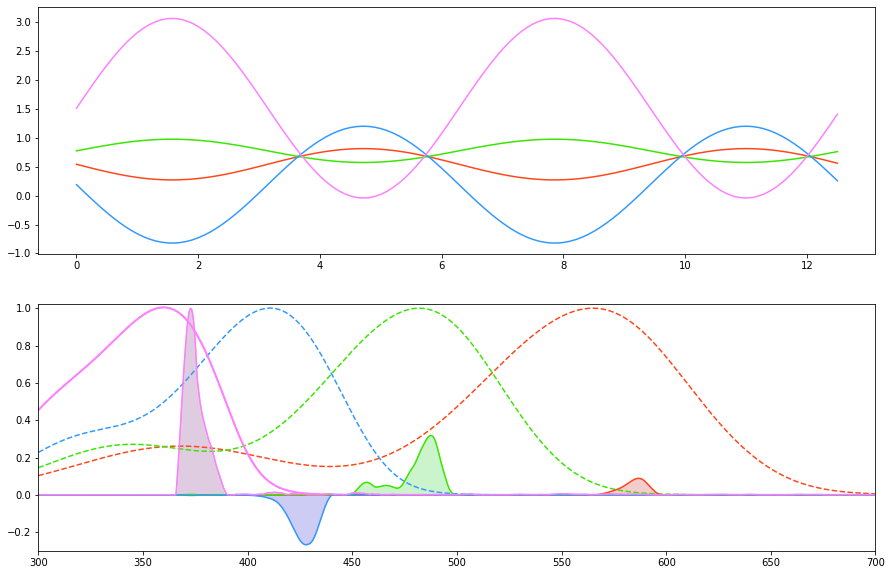

In [57]:
fig,ax = plt.subplots(2,1,figsize = FigureSize)

SWS_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    SWS_ratio = np.zeros((4))
    SWS_ratio[0] = 0.5
    SWS_ratio[1] = 0.5
    SWS_ratio[2] = 0.5
    SWS_ratio[3] = vals[i]
    SWS_Cone_isolation.append(SWS_ratio)
    
SWS_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = N_Matrix@SWS_Cone_isolation[i]
    SWS_LED_ratios.append(LED)
    
SWS_LED_ratios = np.stack(SWS_LED_ratios)

for i in range (nLED):   
    ax[0].plot(X_Stimulus,SWS_LED_ratios[:,i],color=colors[i])
    
for i in range (nCone):
    ax[1].plot(WvsX, Opsin[i], '--', c=colors[i])
ax[1].plot(WvsX, Opsin[3], colors[3],linewidth = 2)

SWS_Ratio = []
for i in range(nLED):
    sws = SWS_LED_ratios[16][i]/np.nanmax((SWS_LED_ratios[16][3]))
    SWS_Ratio.append(sws)
for i in range (nLED):
    ax[1].plot(WvsX, LEDnormalised[i]*SWS_Ratio[i], colors[i])
    ax[1].fill(WvsX, LEDnormalised[i]*SWS_Ratio[i], c=RGBA[i])
    

ax[1].set_ylim(-0.3,1.025)
ax[1].set_xlim(SpectraRange);